In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import decode_image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np

In [2]:
class ConvICNN(nn.Module):
    def __init__(self, linear_layers=4, convex_layers=5, downscale=[(2048, 128), (128, 64), (64, 32), (32, 1)], beta=1e-6):
        super().__init__()
        self.beta = beta
        self.linear_layers = linear_layers
        self.convex_layers = convex_layers
        self.downscale = downscale

        # Linear block
        # Here we use either identity activation or average pooling
        self.conv_direct = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1, bias=False))
        self.conv_sqr = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1, bias=False))
        for i in range(linear_layers - 2):
            self.conv_direct.append(nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False))
            self.conv_sqr.append(nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False))
        self.conv_direct.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))
        self.conv_sqr.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))

        # Convexity-preserving layers
        self.convex_pre_act = nn.CELU()
        self.convex = nn.Sequential()
        for i in range(convex_layers):
            self.convex.append(nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1))#, padding=1, offset=1))
            self.convex.append(nn.CELU())

        self.linear = nn.Sequential()
        for i in range(len(downscale) - 1):
            self.linear.append(nn.Linear(downscale[i][0], downscale[i][1]))
            self.linear.append(nn.CELU())
        self.linear.append(nn.Linear(downscale[-1][0], downscale[-1][1]))


    def forward(self, x):
        x_input = x
        linear = self.conv_direct(x)
        linear += torch.square(self.conv_sqr(x))
        out = self.convex(self.convex_pre_act(linear))
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        strong_convexity = (self.beta / 2) * torch.sum(torch.square(x.reshape(x.size(0), -1)), dim=1, keepdim=True)
        return out + strong_convexity

    def update_weights(self):
        for i in range(0, self.convex_layers):
            # each Conv2d
            self.convex[i*2].weight.data.clamp_(min=0)

        for i in range(0, len(self.downscale)):
            # each Linear
            self.linear[i*2].weight.data.clamp_(min=0)

    def gradient(self, x):
        """Compute gradient of the network w.r.t. input"""
        #if not x.requires_grad:
        #    x = x.clone().requires_grad_(True)
        y = self.forward(x)
        grad = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True,
            retain_graph=True
        )[0]
        return grad#.detach()

In [3]:
class W2GNLoss:
    """
    Wasserstein-2 Generative Network Loss
    """
    def __init__(self, psi_theta, psi_omega, lambda_cycle=1.0, devices=['cuda'], compute_extra_reg=False):
        self.lambda_cycle = lambda_cycle
        self.devices = devices
        self.dev0 = devices[0]
        self.dev1 = devices[1] if len(devices) > 1 else devices[0]
        self.compute_extra_reg = compute_extra_reg

        # Initialize primal and dual potentials
        self.psi_theta = psi_theta.to(self.dev0)
        self.psi_omega = psi_omega.to(self.dev1)

    def theta_device(self):
        return self.dev0

    def omega_device(self):
        return self.dev1

    def to_theta(self, t: torch.Tensor):
        """
        Transfer tensor to psi_theta device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev0, non_blocking=True)
        else:
            return t

    def to_omega(self, t: torch.Tensor):
        """
        Transfer tensor to psi_omega device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev1, non_blocking=True)
        else:
            return t

    def compute_correlations(self, X, Y, grad_psi_omega):
        """
        Compute Monte-Carlo estimate of correlations
        L_Corr = (1/K) * [sum psi_theta(x) + sum(<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y)))]
        """
        batch_size = X.shape[0]

        # Term 1: E_P[psi_theta(x)]
        term1 = self.psi_theta(X).mean()

        # Term 2: E_Q[<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y))]
        # Compute gradient of conjugate potential

        # Inner product <grad_psi_omega(y), y>
        inner_prod = torch.sum(grad_psi_omega * self.to_omega(Y), dim=(1, 2, 3), keepdim=True)

        # Evaluate primal potential at gradient
        psi_at_grad = self.psi_theta(self.to_theta(grad_psi_omega))

        term2 = (self.to_theta(inner_prod) - psi_at_grad).mean()

        return term1 + term2 # THETA

    def compute_cycle_consistency(self, X, Y):
        """
        Compute cycle consistency regularization
        R_Y = E_Q[||grad_psi_theta(grad_psi_omega(y)) - y||^2] + E_Q[||grad_psi_omega(grad_psi_theta(x)) - x||^2]
        """
        # Forward: omega -> theta
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(Y))
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(grad_psi_omega))

        # Compute squared difference
        diff = grad_psi_theta - self.to_theta(Y).detach()
        cycle_loss_y = torch.mean(diff ** 2)

        # Same for X
        grad_psi_theta_x = self.psi_theta.gradient(self.to_theta(X))
        grad_psi_omega_x = self.psi_omega.gradient(self.to_omega(grad_psi_theta_x))

        diff_x = grad_psi_omega_x - self.to_omega(X).detach()
        
        cycle_loss_x = torch.mean(diff_x ** 2)
        cycle_loss = cycle_loss_y + self.to_theta(cycle_loss_x)
        
        return cycle_loss # THETA

    def compute_extra_R(self, X):
        """
        Compute extra regularization term
        R_X = (1/K) * [sum ||grad_psi_omega(grad_psi_theta(x)) - x||^2]
        """
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(X))
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(grad_psi_theta))

        # Compute squared difference
        diff = grad_psi_omega - self.to_omega(X)
        r_reg = torch.mean(torch.sum(diff ** 2, dim=(1, 2, 3)))
        return r_reg # OMEGA

    def compute_reg(self):
        """
        Compute regularization of model params
        """
        reg_total = 0.0
        for p in self.psi_theta.parameters():
            reg_total += torch.sum(torch.abs(p))
        for p in self.psi_omega.parameters():
            reg_total += self.to_theta(torch.sum(torch.abs(p)))
        return reg_total

    def compute_loss(self, opt, X, Y):
        """
        Compute loss and calculate gradients. It is optimal to store X at device 0 and Y at device 1
        Args:
            opt: optimizer
            X: batch from source distribution P
            Y: batch from target distribution Q
        """
        X.requires_grad_(True)
        Y.requires_grad_(True)
        opt[0].zero_grad()
        opt[1].zero_grad()

        # Compute cycle consistency
        loss_cycle = self.compute_cycle_consistency(X, Y)

        grad_psi_omega = self.psi_omega.gradient(self.to_omega(Y))
        grad_psi_omega_d = grad_psi_omega.detach() # heuristic from Appendix C.1

        opt[0].zero_grad()
        opt[1].zero_grad()
        
        # Compute neg W dist & correlations
        loss_W = torch.mean(self.psi_theta(self.to_theta(X)) - self.psi_theta(self.to_theta(grad_psi_omega_d)))
        #with torch.no_grad():
        #    loss_W_const = (- (self.to_omega(X) ** 2).sum(dim=(1, 2, 3)) / 2).mean() + \
        #    ((grad_psi_omega_d * self.to_omega(Y)).sum(dim=(1, 2, 3)) - (self.to_omega(Y) ** 2).sum(dim=(1, 2, 3)) / 2).mean()
        #loss_corr = self.compute_correlations(X, Y, grad_psi_omega_d)

        # Total loss
        if self.compute_extra_reg:
            loss_R = 1e-10 * self.compute_reg() #self.to_theta(self.compute_extra_R(X))
            loss_R_item = loss_R.item()
            #loss_total = loss_corr + (self.lambda_cycle / 2) * loss_cycle + loss_R
            loss_total = loss_W + (self.lambda_cycle / 2) * loss_cycle + loss_R
        else:
            loss_R = None
            loss_R_item = None
            loss_total = loss_W + (self.lambda_cycle / 2) * loss_cycle

        # Gradient step
        loss_total.backward()
        opt[0].step()
        opt[1].step()
        opt[0].zero_grad()
        opt[1].zero_grad()

        return {
            'loss_corr': loss_W.item(),
            'loss_cycle': loss_cycle.item(),
            'loss_total': loss_total.item(),
            'loss_R': loss_R_item
        }

    def pretrain_loss(self, X):
        X.requires_grad_(True)
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(X))
        loss_mse = F.mse_loss(grad_psi_theta, X)
        loss_mse.backward()

        return loss_mse

    def apply_pretrain_weights(self):
        self.psi_omega.load_state_dict(self.psi_theta.state_dict())

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        return self.psi_theta.gradient(X).detach()

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        return self.psi_omega.gradient(Y).detach()

In [4]:
class W2GNTrainer:
    def __init__(self, loss_c, lr=1e-3, pre_lr=1e-3, betas_theta=(0.8, 0.99), betas_omega=(0.4, 0.4)):
        self.loss_c = loss_c
        self.optimizers = [
            torch.optim.Adam(
                list(self.loss_c.psi_theta.parameters()),
                lr=lr, betas=betas_theta
            ),
            torch.optim.Adam(
                list(self.loss_c.psi_omega.parameters()),
                lr=lr, betas=betas_omega
        )]

        self.preoptimizer = torch.optim.Adam(
           list(self.loss_c.psi_theta.parameters()),
           lr=pre_lr
        )

        self.history = {'loss_corr': [], 'loss_cycle': [], 'loss_total': [], 'loss_R': []}
        self.history_pre = []

    def step(self, X, Y):
        #self.optimizer.zero_grad()
        losses = self.loss_c.compute_loss(self.optimizers, X, Y)
        #self.optimizer.step()
        # Clamp weights in convexity-preserving layers to be non-negative
        with torch.no_grad():
            self.loss_c.psi_theta.update_weights()
            self.loss_c.psi_omega.update_weights()

        for x in losses.keys():
            if losses[x] is not None:
                self.history[x].append(losses[x])

        return losses

    def pretrain_step(self, X):
        self.preoptimizer.zero_grad()
        loss = self.loss_c.pretrain_loss(X)
        self.preoptimizer.step()
        with torch.no_grad():
            self.loss_c.psi_theta.update_weights()

        self.history_pre.append(loss)

        return loss

    def apply_pretrain(self):
        self.loss_c.apply_pretrain_weights()
        del self.preoptimizer

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        #with torch.no_grad():
        return self.loss_c.psi_theta.gradient(X)

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        #with torch.no_grad():
        return self.loss_c.psi_omega.gradient(Y)

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/summer2winter-yosemite")

In [6]:
class S2WDataset(torch.utils.data.Dataset):
    def __init__(self, root, target_shape, is_val=False):
        super().__init__()
        self.root = root
        self.target_shape = target_shape
        self.is_val = is_val

        self.trainA = "trainA"
        self.testA = "testA"
        self.trainB = "trainB"
        self.testB = "testB"

        if not is_val:
            #self.df = pd.read_csv(os.path.join(root, "metadata.csv"))
            self.imagesA = os.listdir(os.path.join(root, self.trainA))
            self.imagesB = os.listdir(os.path.join(root, self.trainB))
        else:
            self.imagesA = os.listdir(os.path.join(root, self.testA))
            self.imagesB = os.listdir(os.path.join(root, self.testB))

        self.transforms_A = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.CenterCrop(200),
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ColorJitter(0.025, 0.025, 0.025, 0.025),
            #transforms.ToTensor(),
            #transforms.Lambda(lambda x: x+torch.randn_like(x) * 0.01),
            #transforms.Lambda(lambda t: t.clamp(0,1)),
        ])
        self.transforms_B = self.transforms_A

        self.pics = min(len(self.imagesA), len(self.imagesB))

    def __len__(self):
        return self.pics

    def get(self, idx, pic_dirA, pic_dirB):
        img_pathA = os.path.join(self.root, pic_dirA, self.imagesA[idx])
        img_pathB = os.path.join(self.root, pic_dirB, self.imagesB[idx])

        # Load the image
        imgA = self.transforms_A(Image.open(img_pathA))#.resize((self.target_shape, self.target_shape))
        imgB = self.transforms_B(Image.open(img_pathB))#.resize((self.target_shape, self.target_shape))

        #return torch.stack([self.transforms_A(imgA), self.transforms_B(imgB)])#.permute(0, 3, 1, 2)

        out = torch.as_tensor(np.stack([
            np.asarray(imgA, dtype=np.float32), np.asarray(imgB, dtype=np.float32)
        ]) / 128.0 - 1.0).permute(0, 3, 1, 2)

        #out = out + torch.randn_like(out) * 0.01
        #out = out.clamp(0, 1)
        return out, {}

    @staticmethod
    def take(t, A: bool):
        if A:
            return t[:, 0]
        else:
            return t[:, 1]

    @staticmethod
    def to_image(t):
        return (t.permute(0, 2, 3, 1) + 1.0) * 128.0

    def get_train(self, idx):
        return self.get(idx, self.trainA, self.trainB)

    def get_val(self, idx):
        return self.get(idx, self.testA, self.testB)

    def __getitem__(self, idx):
        if self.is_val:
            return self.get_val(idx)
        return self.get_train(idx)

In [7]:
batch_size = 12
dataset = S2WDataset(path, 128)

datasetVal = S2WDataset(path, 128, is_val=True)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

dataVal = torch.utils.data.DataLoader(
    datasetVal,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

In [8]:
psi_theta = ConvICNN()
psi_omega = ConvICNN()

In [9]:
loss_c = W2GNLoss(psi_theta, psi_omega, lambda_cycle=35000.0, compute_extra_reg=True, devices=["cuda:0", "cuda:1"])
trainer = W2GNTrainer(loss_c, lr=1e-4, pre_lr=1e-4)

In [69]:
# Pretrain
epochs = 5
for epoch in range(epochs):
    A_iter = iter(dataloader)
    for i in tqdm(range(len(dataloader)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        X_src = next(A_iter)[0]
        X = dataloader.dataset.take(X_src, A=True)
        loss = trainer.pretrain_step(X.to(trainer.loss_c.theta_device()))
        print(f"Epoch {epoch}: MSE={loss:.4f}")

Epoch 1/5:   1%|▎                                    | 1/121 [00:00<00:44,  2.70it/s]

Epoch 0: MSE=0.3734


Epoch 1/5:   2%|▌                                    | 2/121 [00:00<00:40,  2.94it/s]

Epoch 0: MSE=1.1808


Epoch 1/5:   2%|▉                                    | 3/121 [00:01<00:38,  3.06it/s]

Epoch 0: MSE=1.9646


Epoch 1/5:   3%|█▏                                   | 4/121 [00:01<00:37,  3.13it/s]

Epoch 0: MSE=1.0787


Epoch 1/5:   4%|█▌                                   | 5/121 [00:01<00:36,  3.18it/s]

Epoch 0: MSE=0.7676


Epoch 1/5:   5%|█▊                                   | 6/121 [00:01<00:36,  3.17it/s]

Epoch 0: MSE=0.5648


Epoch 1/5:   6%|██▏                                  | 7/121 [00:02<00:36,  3.15it/s]

Epoch 0: MSE=0.7033


Epoch 1/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.17it/s]

Epoch 0: MSE=0.7694


Epoch 1/5:   7%|██▊                                  | 9/121 [00:02<00:35,  3.16it/s]

Epoch 0: MSE=0.6783


Epoch 1/5:   8%|██▉                                 | 10/121 [00:03<00:35,  3.16it/s]

Epoch 0: MSE=0.5462


Epoch 1/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.15it/s]

Epoch 0: MSE=0.3734


Epoch 1/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.14it/s]

Epoch 0: MSE=0.3294


Epoch 1/5:  11%|███▊                                | 13/121 [00:04<00:34,  3.17it/s]

Epoch 0: MSE=0.2970


Epoch 1/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.17it/s]

Epoch 0: MSE=0.2775


Epoch 1/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.19it/s]

Epoch 0: MSE=0.3125


Epoch 1/5:  13%|████▊                               | 16/121 [00:05<00:33,  3.17it/s]

Epoch 0: MSE=0.3173


Epoch 1/5:  14%|█████                               | 17/121 [00:05<00:32,  3.17it/s]

Epoch 0: MSE=0.2931


Epoch 1/5:  15%|█████▎                              | 18/121 [00:05<00:32,  3.17it/s]

Epoch 0: MSE=0.2325


Epoch 1/5:  16%|█████▋                              | 19/121 [00:06<00:32,  3.19it/s]

Epoch 0: MSE=0.2148


Epoch 1/5:  17%|█████▉                              | 20/121 [00:06<00:31,  3.16it/s]

Epoch 0: MSE=0.1711


Epoch 1/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.14it/s]

Epoch 0: MSE=0.2227


Epoch 1/5:  18%|██████▌                             | 22/121 [00:06<00:31,  3.16it/s]

Epoch 0: MSE=0.2112


Epoch 1/5:  19%|██████▊                             | 23/121 [00:07<00:30,  3.18it/s]

Epoch 0: MSE=0.1981


Epoch 1/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.20it/s]

Epoch 0: MSE=0.1743


Epoch 1/5:  21%|███████▍                            | 25/121 [00:07<00:30,  3.17it/s]

Epoch 0: MSE=0.1482


Epoch 1/5:  21%|███████▋                            | 26/121 [00:08<00:30,  3.15it/s]

Epoch 0: MSE=0.1410


Epoch 1/5:  22%|████████                            | 27/121 [00:08<00:29,  3.15it/s]

Epoch 0: MSE=0.1203


Epoch 1/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.15it/s]

Epoch 0: MSE=0.1102


Epoch 1/5:  24%|████████▋                           | 29/121 [00:09<00:29,  3.16it/s]

Epoch 0: MSE=0.0889


Epoch 1/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.14it/s]

Epoch 0: MSE=0.1091


Epoch 1/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.14it/s]

Epoch 0: MSE=0.0842


Epoch 1/5:  26%|█████████▌                          | 32/121 [00:10<00:28,  3.17it/s]

Epoch 0: MSE=0.1040


Epoch 1/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.16it/s]

Epoch 0: MSE=0.1081


Epoch 1/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.16it/s]

Epoch 0: MSE=0.0684


Epoch 1/5:  29%|██████████▍                         | 35/121 [00:11<00:27,  3.14it/s]

Epoch 0: MSE=0.0765


Epoch 1/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.15it/s]

Epoch 0: MSE=0.0935


Epoch 1/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.18it/s]

Epoch 0: MSE=0.0643


Epoch 1/5:  31%|███████████▎                        | 38/121 [00:12<00:26,  3.19it/s]

Epoch 0: MSE=0.0845


Epoch 1/5:  32%|███████████▌                        | 39/121 [00:12<00:25,  3.19it/s]

Epoch 0: MSE=0.0762


Epoch 1/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.16it/s]

Epoch 0: MSE=0.0657


Epoch 1/5:  34%|████████████▏                       | 41/121 [00:12<00:25,  3.18it/s]

Epoch 0: MSE=0.0747


Epoch 1/5:  35%|████████████▍                       | 42/121 [00:13<00:24,  3.19it/s]

Epoch 0: MSE=0.0688


Epoch 1/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.21it/s]

Epoch 0: MSE=0.0690


Epoch 1/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.19it/s]

Epoch 0: MSE=0.0577


Epoch 1/5:  37%|█████████████▍                      | 45/121 [00:14<00:24,  3.16it/s]

Epoch 0: MSE=0.0576


Epoch 1/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.18it/s]

Epoch 0: MSE=0.0622


Epoch 1/5:  39%|█████████████▉                      | 47/121 [00:14<00:23,  3.20it/s]

Epoch 0: MSE=0.0749


Epoch 1/5:  40%|██████████████▎                     | 48/121 [00:15<00:22,  3.21it/s]

Epoch 0: MSE=0.0552


Epoch 1/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.18it/s]

Epoch 0: MSE=0.0688


Epoch 1/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.17it/s]

Epoch 0: MSE=0.0644


Epoch 1/5:  42%|███████████████▏                    | 51/121 [00:16<00:22,  3.17it/s]

Epoch 0: MSE=0.0543


Epoch 1/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.16it/s]

Epoch 0: MSE=0.0650


Epoch 1/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.16it/s]

Epoch 0: MSE=0.0617


Epoch 1/5:  45%|████████████████                    | 54/121 [00:17<00:21,  3.14it/s]

Epoch 0: MSE=0.0655


Epoch 1/5:  45%|████████████████▎                   | 55/121 [00:17<00:20,  3.15it/s]

Epoch 0: MSE=0.0559


Epoch 1/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.15it/s]

Epoch 0: MSE=0.0691


Epoch 1/5:  47%|████████████████▉                   | 57/121 [00:18<00:20,  3.17it/s]

Epoch 0: MSE=0.0588


Epoch 1/5:  48%|█████████████████▎                  | 58/121 [00:18<00:19,  3.16it/s]

Epoch 0: MSE=0.0524


Epoch 1/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.14it/s]

Epoch 0: MSE=0.0398


Epoch 1/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.16it/s]

Epoch 0: MSE=0.0580


Epoch 1/5:  50%|██████████████████▏                 | 61/121 [00:19<00:18,  3.16it/s]

Epoch 0: MSE=0.0621


Epoch 1/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.16it/s]

Epoch 0: MSE=0.0494


Epoch 1/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.15it/s]

Epoch 0: MSE=0.0544


Epoch 1/5:  53%|███████████████████                 | 64/121 [00:20<00:18,  3.13it/s]

Epoch 0: MSE=0.0518


Epoch 1/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.13it/s]

Epoch 0: MSE=0.0532


Epoch 1/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.15it/s]

Epoch 0: MSE=0.0610


Epoch 1/5:  55%|███████████████████▉                | 67/121 [00:21<00:17,  3.17it/s]

Epoch 0: MSE=0.0583


Epoch 1/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.15it/s]

Epoch 0: MSE=0.0478


Epoch 1/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.14it/s]

Epoch 0: MSE=0.0548


Epoch 1/5:  58%|████████████████████▊               | 70/121 [00:22<00:16,  3.17it/s]

Epoch 0: MSE=0.0589


Epoch 1/5:  59%|█████████████████████               | 71/121 [00:22<00:15,  3.19it/s]

Epoch 0: MSE=0.0480


Epoch 1/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.19it/s]

Epoch 0: MSE=0.0662


Epoch 1/5:  60%|█████████████████████▋              | 73/121 [00:23<00:15,  3.16it/s]

Epoch 0: MSE=0.0476


Epoch 1/5:  61%|██████████████████████              | 74/121 [00:23<00:14,  3.17it/s]

Epoch 0: MSE=0.0552


Epoch 1/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.19it/s]

Epoch 0: MSE=0.0495


Epoch 1/5:  63%|██████████████████████▌             | 76/121 [00:24<00:14,  3.21it/s]

Epoch 0: MSE=0.0600


Epoch 1/5:  64%|██████████████████████▉             | 77/121 [00:24<00:13,  3.21it/s]

Epoch 0: MSE=0.0439


Epoch 1/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.18it/s]

Epoch 0: MSE=0.0456


Epoch 1/5:  65%|███████████████████████▌            | 79/121 [00:24<00:13,  3.19it/s]

Epoch 0: MSE=0.0546


Epoch 1/5:  66%|███████████████████████▊            | 80/121 [00:25<00:12,  3.21it/s]

Epoch 0: MSE=0.0638


Epoch 1/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.22it/s]

Epoch 0: MSE=0.0586


Epoch 1/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.21it/s]

Epoch 0: MSE=0.0612


Epoch 1/5:  69%|████████████████████████▋           | 83/121 [00:26<00:11,  3.18it/s]

Epoch 0: MSE=0.0527


Epoch 1/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.20it/s]

Epoch 0: MSE=0.0499


Epoch 1/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.22it/s]

Epoch 0: MSE=0.0513


Epoch 1/5:  71%|█████████████████████████▌          | 86/121 [00:27<00:10,  3.22it/s]

Epoch 0: MSE=0.0587


Epoch 1/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.20it/s]

Epoch 0: MSE=0.0434


Epoch 1/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.18it/s]

Epoch 0: MSE=0.0471


Epoch 1/5:  74%|██████████████████████████▍         | 89/121 [00:28<00:09,  3.20it/s]

Epoch 0: MSE=0.0436


Epoch 1/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.22it/s]

Epoch 0: MSE=0.0458


Epoch 1/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.23it/s]

Epoch 0: MSE=0.0484


Epoch 1/5:  76%|███████████████████████████▎        | 92/121 [00:29<00:09,  3.19it/s]

Epoch 0: MSE=0.0474


Epoch 1/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.18it/s]

Epoch 0: MSE=0.0431


Epoch 1/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.21it/s]

Epoch 0: MSE=0.0498


Epoch 1/5:  79%|████████████████████████████▎       | 95/121 [00:29<00:08,  3.22it/s]

Epoch 0: MSE=0.0512


Epoch 1/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.22it/s]

Epoch 0: MSE=0.0395


Epoch 1/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.19it/s]

Epoch 0: MSE=0.0469


Epoch 1/5:  81%|█████████████████████████████▏      | 98/121 [00:30<00:07,  3.19it/s]

Epoch 0: MSE=0.0513


Epoch 1/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:06,  3.21it/s]

Epoch 0: MSE=0.0491


Epoch 1/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.22it/s]

Epoch 0: MSE=0.0402


Epoch 1/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.22it/s]

Epoch 0: MSE=0.0431


Epoch 1/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:05,  3.19it/s]

Epoch 0: MSE=0.0531


Epoch 1/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.20it/s]

Epoch 0: MSE=0.0411


Epoch 1/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.21it/s]

Epoch 0: MSE=0.0457


Epoch 1/5:  87%|██████████████████████████████▎    | 105/121 [00:33<00:04,  3.22it/s]

Epoch 0: MSE=0.0424


Epoch 1/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.21it/s]

Epoch 0: MSE=0.0590


Epoch 1/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.18it/s]

Epoch 0: MSE=0.0448


Epoch 1/5:  89%|███████████████████████████████▏   | 108/121 [00:34<00:04,  3.20it/s]

Epoch 0: MSE=0.0500


Epoch 1/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.21it/s]

Epoch 0: MSE=0.0379


Epoch 1/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.23it/s]

Epoch 0: MSE=0.0457


Epoch 1/5:  92%|████████████████████████████████   | 111/121 [00:34<00:03,  3.20it/s]

Epoch 0: MSE=0.0529


Epoch 1/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.18it/s]

Epoch 0: MSE=0.0447


Epoch 1/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.20it/s]

Epoch 0: MSE=0.0482


Epoch 1/5:  94%|████████████████████████████████▉  | 114/121 [00:35<00:02,  3.22it/s]

Epoch 0: MSE=0.0490


Epoch 1/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.23it/s]

Epoch 0: MSE=0.0364


Epoch 1/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.20it/s]

Epoch 0: MSE=0.0375


Epoch 1/5:  97%|█████████████████████████████████▊ | 117/121 [00:36<00:01,  3.18it/s]

Epoch 0: MSE=0.0449


Epoch 1/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.20it/s]

Epoch 0: MSE=0.0453


Epoch 1/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.22it/s]

Epoch 0: MSE=0.0332


Epoch 0: MSE=0.0576
Epoch 0: MSE=0.0491


Epoch 2/5:   1%|▎                                    | 1/121 [00:00<00:39,  3.00it/s]

Epoch 1: MSE=0.0377


Epoch 2/5:   2%|▌                                    | 2/121 [00:00<00:37,  3.14it/s]

Epoch 1: MSE=0.0423


Epoch 2/5:   2%|▉                                    | 3/121 [00:00<00:36,  3.19it/s]

Epoch 1: MSE=0.0476


Epoch 2/5:   3%|█▏                                   | 4/121 [00:01<00:36,  3.21it/s]

Epoch 1: MSE=0.0423


Epoch 2/5:   4%|█▌                                   | 5/121 [00:01<00:36,  3.18it/s]

Epoch 1: MSE=0.0380


Epoch 2/5:   5%|█▊                                   | 6/121 [00:01<00:36,  3.17it/s]

Epoch 1: MSE=0.0421


Epoch 2/5:   6%|██▏                                  | 7/121 [00:02<00:35,  3.20it/s]

Epoch 1: MSE=0.0467


Epoch 2/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.21it/s]

Epoch 1: MSE=0.0496


Epoch 2/5:   7%|██▊                                  | 9/121 [00:02<00:34,  3.21it/s]

Epoch 1: MSE=0.0426


Epoch 2/5:   8%|██▉                                 | 10/121 [00:03<00:34,  3.18it/s]

Epoch 1: MSE=0.0512


Epoch 2/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.18it/s]

Epoch 1: MSE=0.0408


Epoch 2/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.20it/s]

Epoch 1: MSE=0.0374


Epoch 2/5:  11%|███▊                                | 13/121 [00:04<00:33,  3.21it/s]

Epoch 1: MSE=0.0393


Epoch 2/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.21it/s]

Epoch 1: MSE=0.0380


Epoch 2/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.18it/s]

Epoch 1: MSE=0.0358


Epoch 2/5:  13%|████▊                               | 16/121 [00:05<00:32,  3.19it/s]

Epoch 1: MSE=0.0340


Epoch 2/5:  14%|█████                               | 17/121 [00:05<00:32,  3.21it/s]

Epoch 1: MSE=0.0369


Epoch 2/5:  15%|█████▎                              | 18/121 [00:05<00:31,  3.22it/s]

Epoch 1: MSE=0.0320


Epoch 2/5:  16%|█████▋                              | 19/121 [00:05<00:31,  3.21it/s]

Epoch 1: MSE=0.0397


Epoch 2/5:  17%|█████▉                              | 20/121 [00:06<00:31,  3.18it/s]

Epoch 1: MSE=0.0471


Epoch 2/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.17it/s]

Epoch 1: MSE=0.0473


Epoch 2/5:  18%|██████▌                             | 22/121 [00:06<00:31,  3.15it/s]

Epoch 1: MSE=0.0429


Epoch 2/5:  19%|██████▊                             | 23/121 [00:07<00:30,  3.18it/s]

Epoch 1: MSE=0.0401


Epoch 2/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.16it/s]

Epoch 1: MSE=0.0357


Epoch 2/5:  21%|███████▍                            | 25/121 [00:07<00:30,  3.15it/s]

Epoch 1: MSE=0.0395


Epoch 2/5:  21%|███████▋                            | 26/121 [00:08<00:29,  3.18it/s]

Epoch 1: MSE=0.0368


Epoch 2/5:  22%|████████                            | 27/121 [00:08<00:29,  3.16it/s]

Epoch 1: MSE=0.0340


Epoch 2/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.16it/s]

Epoch 1: MSE=0.0465


Epoch 2/5:  24%|████████▋                           | 29/121 [00:09<00:29,  3.14it/s]

Epoch 1: MSE=0.0384


Epoch 2/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.15it/s]

Epoch 1: MSE=0.0390


Epoch 2/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.17it/s]

Epoch 1: MSE=0.0386


Epoch 2/5:  26%|█████████▌                          | 32/121 [00:10<00:27,  3.18it/s]

Epoch 1: MSE=0.0430


Epoch 2/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.17it/s]

Epoch 1: MSE=0.0426


Epoch 2/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.16it/s]

Epoch 1: MSE=0.0348


Epoch 2/5:  29%|██████████▍                         | 35/121 [00:11<00:27,  3.17it/s]

Epoch 1: MSE=0.0342


Epoch 2/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.19it/s]

Epoch 1: MSE=0.0373


Epoch 2/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.21it/s]

Epoch 1: MSE=0.0370


Epoch 2/5:  31%|███████████▎                        | 38/121 [00:11<00:25,  3.20it/s]

Epoch 1: MSE=0.0453


Epoch 2/5:  32%|███████████▌                        | 39/121 [00:12<00:25,  3.17it/s]

Epoch 1: MSE=0.0518


Epoch 2/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.19it/s]

Epoch 1: MSE=0.0324


Epoch 2/5:  34%|████████████▏                       | 41/121 [00:12<00:24,  3.21it/s]

Epoch 1: MSE=0.0325


Epoch 2/5:  35%|████████████▍                       | 42/121 [00:13<00:24,  3.22it/s]

Epoch 1: MSE=0.0386


Epoch 2/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.20it/s]

Epoch 1: MSE=0.0332


Epoch 2/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.18it/s]

Epoch 1: MSE=0.0418


Epoch 2/5:  37%|█████████████▍                      | 45/121 [00:14<00:23,  3.20it/s]

Epoch 1: MSE=0.0451


Epoch 2/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.21it/s]

Epoch 1: MSE=0.0292


Epoch 2/5:  39%|█████████████▉                      | 47/121 [00:14<00:22,  3.22it/s]

Epoch 1: MSE=0.0383


Epoch 2/5:  40%|██████████████▎                     | 48/121 [00:15<00:22,  3.19it/s]

Epoch 1: MSE=0.0334


Epoch 2/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.18it/s]

Epoch 1: MSE=0.0375


Epoch 2/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.20it/s]

Epoch 1: MSE=0.0337


Epoch 2/5:  42%|███████████████▏                    | 51/121 [00:16<00:21,  3.22it/s]

Epoch 1: MSE=0.0427


Epoch 2/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.22it/s]

Epoch 1: MSE=0.0392


Epoch 2/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.19it/s]

Epoch 1: MSE=0.0324


Epoch 2/5:  45%|████████████████                    | 54/121 [00:16<00:21,  3.19it/s]

Epoch 1: MSE=0.0415


Epoch 2/5:  45%|████████████████▎                   | 55/121 [00:17<00:20,  3.20it/s]

Epoch 1: MSE=0.0306


Epoch 2/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.22it/s]

Epoch 1: MSE=0.0304


Epoch 2/5:  47%|████████████████▉                   | 57/121 [00:17<00:19,  3.21it/s]

Epoch 1: MSE=0.0399


Epoch 2/5:  48%|█████████████████▎                  | 58/121 [00:18<00:19,  3.18it/s]

Epoch 1: MSE=0.0395


Epoch 2/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.19it/s]

Epoch 1: MSE=0.0318


Epoch 2/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.21it/s]

Epoch 1: MSE=0.0342


Epoch 2/5:  50%|██████████████████▏                 | 61/121 [00:19<00:18,  3.21it/s]

Epoch 1: MSE=0.0405


Epoch 2/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.20it/s]

Epoch 1: MSE=0.0376


Epoch 2/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.17it/s]

Epoch 1: MSE=0.0335


Epoch 2/5:  53%|███████████████████                 | 64/121 [00:20<00:17,  3.19it/s]

Epoch 1: MSE=0.0451


Epoch 2/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.20it/s]

Epoch 1: MSE=0.0435


Epoch 2/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.21it/s]

Epoch 1: MSE=0.0350


Epoch 2/5:  55%|███████████████████▉                | 67/121 [00:21<00:16,  3.18it/s]

Epoch 1: MSE=0.0311


Epoch 2/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.16it/s]

Epoch 1: MSE=0.0465


Epoch 2/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.18it/s]

Epoch 1: MSE=0.0341


Epoch 2/5:  58%|████████████████████▊               | 70/121 [00:21<00:15,  3.20it/s]

Epoch 1: MSE=0.0378


Epoch 2/5:  59%|█████████████████████               | 71/121 [00:22<00:15,  3.21it/s]

Epoch 1: MSE=0.0320


Epoch 2/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.17it/s]

Epoch 1: MSE=0.0302


Epoch 2/5:  60%|█████████████████████▋              | 73/121 [00:22<00:15,  3.16it/s]

Epoch 1: MSE=0.0436


Epoch 2/5:  61%|██████████████████████              | 74/121 [00:23<00:14,  3.18it/s]

Epoch 1: MSE=0.0334


Epoch 2/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.20it/s]

Epoch 1: MSE=0.0348


Epoch 2/5:  63%|██████████████████████▌             | 76/121 [00:23<00:14,  3.20it/s]

Epoch 1: MSE=0.0303


Epoch 2/5:  64%|██████████████████████▉             | 77/121 [00:24<00:13,  3.17it/s]

Epoch 1: MSE=0.0257


Epoch 2/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.17it/s]

Epoch 1: MSE=0.0360


Epoch 2/5:  65%|███████████████████████▌            | 79/121 [00:24<00:13,  3.18it/s]

Epoch 1: MSE=0.0290


Epoch 2/5:  66%|███████████████████████▊            | 80/121 [00:25<00:12,  3.20it/s]

Epoch 1: MSE=0.0366


Epoch 2/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.19it/s]

Epoch 1: MSE=0.0284


Epoch 2/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.16it/s]

Epoch 1: MSE=0.0450


Epoch 2/5:  69%|████████████████████████▋           | 83/121 [00:26<00:11,  3.17it/s]

Epoch 1: MSE=0.0438


Epoch 2/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.19it/s]

Epoch 1: MSE=0.0360


Epoch 2/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.20it/s]

Epoch 1: MSE=0.0343


Epoch 2/5:  71%|█████████████████████████▌          | 86/121 [00:26<00:10,  3.18it/s]

Epoch 1: MSE=0.0442


Epoch 2/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.16it/s]

Epoch 1: MSE=0.0330


Epoch 2/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.18it/s]

Epoch 1: MSE=0.0248


Epoch 2/5:  74%|██████████████████████████▍         | 89/121 [00:27<00:10,  3.20it/s]

Epoch 1: MSE=0.0354


Epoch 2/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.21it/s]

Epoch 1: MSE=0.0286


Epoch 2/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.17it/s]

Epoch 1: MSE=0.0410


Epoch 2/5:  76%|███████████████████████████▎        | 92/121 [00:28<00:09,  3.16it/s]

Epoch 1: MSE=0.0351


Epoch 2/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.18it/s]

Epoch 1: MSE=0.0347


Epoch 2/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.20it/s]

Epoch 1: MSE=0.0311


Epoch 2/5:  79%|████████████████████████████▎       | 95/121 [00:29<00:08,  3.20it/s]

Epoch 1: MSE=0.0285


Epoch 2/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.17it/s]

Epoch 1: MSE=0.0399


Epoch 2/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.17it/s]

Epoch 1: MSE=0.0291


Epoch 2/5:  81%|█████████████████████████████▏      | 98/121 [00:30<00:07,  3.19it/s]

Epoch 1: MSE=0.0227


Epoch 2/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:06,  3.20it/s]

Epoch 1: MSE=0.0396


Epoch 2/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.19it/s]

Epoch 1: MSE=0.0293


Epoch 2/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.16it/s]

Epoch 1: MSE=0.0338


Epoch 2/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:05,  3.17it/s]

Epoch 1: MSE=0.0261


Epoch 2/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.19it/s]

Epoch 1: MSE=0.0284


Epoch 2/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.20it/s]

Epoch 1: MSE=0.0367


Epoch 2/5:  87%|██████████████████████████████▎    | 105/121 [00:32<00:05,  3.19it/s]

Epoch 1: MSE=0.0360


Epoch 2/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.16it/s]

Epoch 1: MSE=0.0315


Epoch 2/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.18it/s]

Epoch 1: MSE=0.0382


Epoch 2/5:  89%|███████████████████████████████▏   | 108/121 [00:33<00:04,  3.19it/s]

Epoch 1: MSE=0.0336


Epoch 2/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.20it/s]

Epoch 1: MSE=0.0340


Epoch 2/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.18it/s]

Epoch 1: MSE=0.0334


Epoch 2/5:  92%|████████████████████████████████   | 111/121 [00:34<00:03,  3.16it/s]

Epoch 1: MSE=0.0263


Epoch 2/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.18it/s]

Epoch 1: MSE=0.0351


Epoch 2/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.20it/s]

Epoch 1: MSE=0.0305


Epoch 2/5:  94%|████████████████████████████████▉  | 114/121 [00:35<00:02,  3.21it/s]

Epoch 1: MSE=0.0345


Epoch 2/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.17it/s]

Epoch 1: MSE=0.0431


Epoch 2/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.17it/s]

Epoch 1: MSE=0.0320


Epoch 2/5:  97%|█████████████████████████████████▊ | 117/121 [00:36<00:01,  3.18it/s]

Epoch 1: MSE=0.0304


Epoch 2/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.20it/s]

Epoch 1: MSE=0.0302


Epoch 2/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.19it/s]

Epoch 1: MSE=0.0397


Epoch 1: MSE=0.0283
Epoch 1: MSE=0.0339


Epoch 3/5:   1%|▎                                    | 1/121 [00:00<00:39,  3.07it/s]

Epoch 2: MSE=0.0348


Epoch 3/5:   2%|▌                                    | 2/121 [00:00<00:37,  3.16it/s]

Epoch 2: MSE=0.0233


Epoch 3/5:   2%|▉                                    | 3/121 [00:00<00:37,  3.18it/s]

Epoch 2: MSE=0.0297


Epoch 3/5:   3%|█▏                                   | 4/121 [00:01<00:37,  3.15it/s]

Epoch 2: MSE=0.0321


Epoch 3/5:   4%|█▌                                   | 5/121 [00:01<00:36,  3.16it/s]

Epoch 2: MSE=0.0306


Epoch 3/5:   5%|█▊                                   | 6/121 [00:01<00:36,  3.18it/s]

Epoch 2: MSE=0.0314


Epoch 3/5:   6%|██▏                                  | 7/121 [00:02<00:35,  3.20it/s]

Epoch 2: MSE=0.0290


Epoch 3/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.19it/s]

Epoch 2: MSE=0.0316


Epoch 3/5:   7%|██▊                                  | 9/121 [00:02<00:35,  3.16it/s]

Epoch 2: MSE=0.0302


Epoch 3/5:   8%|██▉                                 | 10/121 [00:03<00:35,  3.17it/s]

Epoch 2: MSE=0.0273


Epoch 3/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.19it/s]

Epoch 2: MSE=0.0316


Epoch 3/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.20it/s]

Epoch 2: MSE=0.0356


Epoch 3/5:  11%|███▊                                | 13/121 [00:04<00:33,  3.19it/s]

Epoch 2: MSE=0.0269


Epoch 3/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.16it/s]

Epoch 2: MSE=0.0379


Epoch 3/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.18it/s]

Epoch 2: MSE=0.0409


Epoch 3/5:  13%|████▊                               | 16/121 [00:05<00:32,  3.19it/s]

Epoch 2: MSE=0.0307


Epoch 3/5:  14%|█████                               | 17/121 [00:05<00:32,  3.20it/s]

Epoch 2: MSE=0.0291


Epoch 3/5:  15%|█████▎                              | 18/121 [00:05<00:32,  3.17it/s]

Epoch 2: MSE=0.0284


Epoch 3/5:  16%|█████▋                              | 19/121 [00:05<00:32,  3.16it/s]

Epoch 2: MSE=0.0283


Epoch 3/5:  17%|█████▉                              | 20/121 [00:06<00:31,  3.18it/s]

Epoch 2: MSE=0.0328


Epoch 3/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.19it/s]

Epoch 2: MSE=0.0289


Epoch 3/5:  18%|██████▌                             | 22/121 [00:06<00:30,  3.20it/s]

Epoch 2: MSE=0.0283


Epoch 3/5:  19%|██████▊                             | 23/121 [00:07<00:30,  3.17it/s]

Epoch 2: MSE=0.0293


Epoch 3/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.16it/s]

Epoch 2: MSE=0.0287


Epoch 3/5:  21%|███████▍                            | 25/121 [00:07<00:30,  3.18it/s]

Epoch 2: MSE=0.0224


Epoch 3/5:  21%|███████▋                            | 26/121 [00:08<00:29,  3.20it/s]

Epoch 2: MSE=0.0306


Epoch 3/5:  22%|████████                            | 27/121 [00:08<00:29,  3.19it/s]

Epoch 2: MSE=0.0261


Epoch 3/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.16it/s]

Epoch 2: MSE=0.0326


Epoch 3/5:  24%|████████▋                           | 29/121 [00:09<00:29,  3.17it/s]

Epoch 2: MSE=0.0284


Epoch 3/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.18it/s]

Epoch 2: MSE=0.0279


Epoch 3/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.20it/s]

Epoch 2: MSE=0.0293


Epoch 3/5:  26%|█████████▌                          | 32/121 [00:10<00:27,  3.18it/s]

Epoch 2: MSE=0.0274


Epoch 3/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.16it/s]

Epoch 2: MSE=0.0276


Epoch 3/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.18it/s]

Epoch 2: MSE=0.0262


Epoch 3/5:  29%|██████████▍                         | 35/121 [00:11<00:26,  3.19it/s]

Epoch 2: MSE=0.0323


Epoch 3/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.20it/s]

Epoch 2: MSE=0.0280


Epoch 3/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.18it/s]

Epoch 2: MSE=0.0332


Epoch 3/5:  31%|███████████▎                        | 38/121 [00:11<00:26,  3.16it/s]

Epoch 2: MSE=0.0312


Epoch 3/5:  32%|███████████▌                        | 39/121 [00:12<00:25,  3.17it/s]

Epoch 2: MSE=0.0264


Epoch 3/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.19it/s]

Epoch 2: MSE=0.0375


Epoch 3/5:  34%|████████████▏                       | 41/121 [00:12<00:24,  3.20it/s]

Epoch 2: MSE=0.0284


Epoch 3/5:  35%|████████████▍                       | 42/121 [00:13<00:24,  3.17it/s]

Epoch 2: MSE=0.0261


Epoch 3/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.16it/s]

Epoch 2: MSE=0.0399


Epoch 3/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.18it/s]

Epoch 2: MSE=0.0280


Epoch 3/5:  37%|█████████████▍                      | 45/121 [00:14<00:23,  3.19it/s]

Epoch 2: MSE=0.0341


Epoch 3/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.19it/s]

Epoch 2: MSE=0.0291


Epoch 3/5:  39%|█████████████▉                      | 47/121 [00:14<00:23,  3.16it/s]

Epoch 2: MSE=0.0333


Epoch 3/5:  40%|██████████████▎                     | 48/121 [00:15<00:23,  3.16it/s]

Epoch 2: MSE=0.0270


Epoch 3/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.18it/s]

Epoch 2: MSE=0.0260


Epoch 3/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.19it/s]

Epoch 2: MSE=0.0331


Epoch 3/5:  42%|███████████████▏                    | 51/121 [00:16<00:21,  3.19it/s]

Epoch 2: MSE=0.0227


Epoch 3/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.16it/s]

Epoch 2: MSE=0.0343


Epoch 3/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.17it/s]

Epoch 2: MSE=0.0254


Epoch 3/5:  45%|████████████████                    | 54/121 [00:16<00:21,  3.19it/s]

Epoch 2: MSE=0.0241


Epoch 3/5:  45%|████████████████▎                   | 55/121 [00:17<00:20,  3.20it/s]

Epoch 2: MSE=0.0338


Epoch 3/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.18it/s]

Epoch 2: MSE=0.0291


Epoch 3/5:  47%|████████████████▉                   | 57/121 [00:17<00:20,  3.15it/s]

Epoch 2: MSE=0.0301


Epoch 3/5:  48%|█████████████████▎                  | 58/121 [00:18<00:19,  3.18it/s]

Epoch 2: MSE=0.0217


Epoch 3/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.19it/s]

Epoch 2: MSE=0.0267


Epoch 3/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.20it/s]

Epoch 2: MSE=0.0295


Epoch 3/5:  50%|██████████████████▏                 | 61/121 [00:19<00:18,  3.17it/s]

Epoch 2: MSE=0.0313


Epoch 3/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.16it/s]

Epoch 2: MSE=0.0323


Epoch 3/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.18it/s]

Epoch 2: MSE=0.0266


Epoch 3/5:  53%|███████████████████                 | 64/121 [00:20<00:17,  3.20it/s]

Epoch 2: MSE=0.0335


Epoch 3/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.20it/s]

Epoch 2: MSE=0.0261


Epoch 3/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.17it/s]

Epoch 2: MSE=0.0357


Epoch 3/5:  55%|███████████████████▉                | 67/121 [00:21<00:17,  3.17it/s]

Epoch 2: MSE=0.0260


Epoch 3/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.18it/s]

Epoch 2: MSE=0.0282


Epoch 3/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.19it/s]

Epoch 2: MSE=0.0267


Epoch 3/5:  58%|████████████████████▊               | 70/121 [00:22<00:15,  3.19it/s]

Epoch 2: MSE=0.0260


Epoch 3/5:  59%|█████████████████████               | 71/121 [00:22<00:15,  3.16it/s]

Epoch 2: MSE=0.0295


Epoch 3/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.17it/s]

Epoch 2: MSE=0.0224


Epoch 3/5:  60%|█████████████████████▋              | 73/121 [00:22<00:15,  3.19it/s]

Epoch 2: MSE=0.0271


Epoch 3/5:  61%|██████████████████████              | 74/121 [00:23<00:14,  3.20it/s]

Epoch 2: MSE=0.0290


Epoch 3/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.18it/s]

Epoch 2: MSE=0.0293


Epoch 3/5:  63%|██████████████████████▌             | 76/121 [00:23<00:14,  3.15it/s]

Epoch 2: MSE=0.0310


Epoch 3/5:  64%|██████████████████████▉             | 77/121 [00:24<00:13,  3.18it/s]

Epoch 2: MSE=0.0201


Epoch 3/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.19it/s]

Epoch 2: MSE=0.0218


Epoch 3/5:  65%|███████████████████████▌            | 79/121 [00:24<00:13,  3.20it/s]

Epoch 2: MSE=0.0249


Epoch 3/5:  66%|███████████████████████▊            | 80/121 [00:25<00:12,  3.17it/s]

Epoch 2: MSE=0.0262


Epoch 3/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.15it/s]

Epoch 2: MSE=0.0271


Epoch 3/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.17it/s]

Epoch 2: MSE=0.0304


Epoch 3/5:  69%|████████████████████████▋           | 83/121 [00:26<00:11,  3.19it/s]

Epoch 2: MSE=0.0267


Epoch 3/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.20it/s]

Epoch 2: MSE=0.0277


Epoch 3/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.16it/s]

Epoch 2: MSE=0.0242


Epoch 3/5:  71%|█████████████████████████▌          | 86/121 [00:27<00:11,  3.16it/s]

Epoch 2: MSE=0.0220


Epoch 3/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.18it/s]

Epoch 2: MSE=0.0261


Epoch 3/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.19it/s]

Epoch 2: MSE=0.0328


Epoch 3/5:  74%|██████████████████████████▍         | 89/121 [00:27<00:10,  3.19it/s]

Epoch 2: MSE=0.0265


Epoch 3/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.16it/s]

Epoch 2: MSE=0.0307


Epoch 3/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.17it/s]

Epoch 2: MSE=0.0257


Epoch 3/5:  76%|███████████████████████████▎        | 92/121 [00:28<00:09,  3.18it/s]

Epoch 2: MSE=0.0249


Epoch 3/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.20it/s]

Epoch 2: MSE=0.0261


Epoch 3/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.18it/s]

Epoch 2: MSE=0.0239


Epoch 3/5:  79%|████████████████████████████▎       | 95/121 [00:29<00:08,  3.15it/s]

Epoch 2: MSE=0.0249


Epoch 3/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.17it/s]

Epoch 2: MSE=0.0203


Epoch 3/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.19it/s]

Epoch 2: MSE=0.0217


Epoch 3/5:  81%|█████████████████████████████▏      | 98/121 [00:30<00:07,  3.20it/s]

Epoch 2: MSE=0.0242


Epoch 3/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:06,  3.18it/s]

Epoch 2: MSE=0.0243


Epoch 3/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.16it/s]

Epoch 2: MSE=0.0210


Epoch 3/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.18it/s]

Epoch 2: MSE=0.0208


Epoch 3/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:05,  3.19it/s]

Epoch 2: MSE=0.0246


Epoch 3/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.20it/s]

Epoch 2: MSE=0.0274


Epoch 3/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.17it/s]

Epoch 2: MSE=0.0284


Epoch 3/5:  87%|██████████████████████████████▎    | 105/121 [00:33<00:05,  3.16it/s]

Epoch 2: MSE=0.0332


Epoch 3/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.18it/s]

Epoch 2: MSE=0.0284


Epoch 3/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.19it/s]

Epoch 2: MSE=0.0254


Epoch 3/5:  89%|███████████████████████████████▏   | 108/121 [00:33<00:04,  3.19it/s]

Epoch 2: MSE=0.0230


Epoch 3/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.16it/s]

Epoch 2: MSE=0.0232


Epoch 3/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.16it/s]

Epoch 2: MSE=0.0247


Epoch 3/5:  92%|████████████████████████████████   | 111/121 [00:34<00:03,  3.18it/s]

Epoch 2: MSE=0.0248


Epoch 3/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.19it/s]

Epoch 2: MSE=0.0271


Epoch 3/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.18it/s]

Epoch 2: MSE=0.0253


Epoch 3/5:  94%|████████████████████████████████▉  | 114/121 [00:35<00:02,  3.15it/s]

Epoch 2: MSE=0.0199


Epoch 3/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.17it/s]

Epoch 2: MSE=0.0255


Epoch 3/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.18it/s]

Epoch 2: MSE=0.0224


Epoch 3/5:  97%|█████████████████████████████████▊ | 117/121 [00:36<00:01,  3.20it/s]

Epoch 2: MSE=0.0265


Epoch 3/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.17it/s]

Epoch 2: MSE=0.0208


Epoch 3/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.15it/s]

Epoch 2: MSE=0.0266


Epoch 2: MSE=0.0199
Epoch 2: MSE=0.0227


Epoch 4/5:   1%|▎                                    | 1/121 [00:00<00:39,  3.04it/s]

Epoch 3: MSE=0.0198


Epoch 4/5:   2%|▌                                    | 2/121 [00:00<00:38,  3.10it/s]

Epoch 3: MSE=0.0235


Epoch 4/5:   2%|▉                                    | 3/121 [00:00<00:38,  3.09it/s]

Epoch 3: MSE=0.0213


Epoch 4/5:   3%|█▏                                   | 4/121 [00:01<00:37,  3.15it/s]

Epoch 3: MSE=0.0241


Epoch 4/5:   4%|█▌                                   | 5/121 [00:01<00:36,  3.17it/s]

Epoch 3: MSE=0.0234


Epoch 4/5:   5%|█▊                                   | 6/121 [00:01<00:36,  3.19it/s]

Epoch 3: MSE=0.0278


Epoch 4/5:   6%|██▏                                  | 7/121 [00:02<00:36,  3.16it/s]

Epoch 3: MSE=0.0214


Epoch 4/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.15it/s]

Epoch 3: MSE=0.0279


Epoch 4/5:   7%|██▊                                  | 9/121 [00:02<00:35,  3.17it/s]

Epoch 3: MSE=0.0257


Epoch 4/5:   8%|██▉                                 | 10/121 [00:03<00:34,  3.19it/s]

Epoch 3: MSE=0.0209


Epoch 4/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.20it/s]

Epoch 3: MSE=0.0211


Epoch 4/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.16it/s]

Epoch 3: MSE=0.0244


Epoch 4/5:  11%|███▊                                | 13/121 [00:04<00:34,  3.16it/s]

Epoch 3: MSE=0.0228


Epoch 4/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.17it/s]

Epoch 3: MSE=0.0225


Epoch 4/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.19it/s]

Epoch 3: MSE=0.0195


Epoch 4/5:  13%|████▊                               | 16/121 [00:05<00:32,  3.18it/s]

Epoch 3: MSE=0.0253


Epoch 4/5:  14%|█████                               | 17/121 [00:05<00:32,  3.15it/s]

Epoch 3: MSE=0.0215


Epoch 4/5:  15%|█████▎                              | 18/121 [00:05<00:32,  3.16it/s]

Epoch 3: MSE=0.0248


Epoch 4/5:  16%|█████▋                              | 19/121 [00:06<00:32,  3.18it/s]

Epoch 3: MSE=0.0237


Epoch 4/5:  17%|█████▉                              | 20/121 [00:06<00:31,  3.20it/s]

Epoch 3: MSE=0.0230


Epoch 4/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.18it/s]

Epoch 3: MSE=0.0266


Epoch 4/5:  18%|██████▌                             | 22/121 [00:06<00:31,  3.15it/s]

Epoch 3: MSE=0.0183


Epoch 4/5:  19%|██████▊                             | 23/121 [00:07<00:30,  3.17it/s]

Epoch 3: MSE=0.0218


Epoch 4/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.19it/s]

Epoch 3: MSE=0.0208


Epoch 4/5:  21%|███████▍                            | 25/121 [00:07<00:30,  3.20it/s]

Epoch 3: MSE=0.0232


Epoch 4/5:  21%|███████▋                            | 26/121 [00:08<00:29,  3.17it/s]

Epoch 3: MSE=0.0279


Epoch 4/5:  22%|████████                            | 27/121 [00:08<00:29,  3.15it/s]

Epoch 3: MSE=0.0277


Epoch 4/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.18it/s]

Epoch 3: MSE=0.0228


Epoch 4/5:  24%|████████▋                           | 29/121 [00:09<00:28,  3.19it/s]

Epoch 3: MSE=0.0243


Epoch 4/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.20it/s]

Epoch 3: MSE=0.0259


Epoch 4/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.16it/s]

Epoch 3: MSE=0.0206


Epoch 4/5:  26%|█████████▌                          | 32/121 [00:10<00:28,  3.16it/s]

Epoch 3: MSE=0.0238


Epoch 4/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.17it/s]

Epoch 3: MSE=0.0244


Epoch 4/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.19it/s]

Epoch 3: MSE=0.0256


Epoch 4/5:  29%|██████████▍                         | 35/121 [00:11<00:26,  3.19it/s]

Epoch 3: MSE=0.0172


Epoch 4/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.15it/s]

Epoch 3: MSE=0.0190


Epoch 4/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.16it/s]

Epoch 3: MSE=0.0262


Epoch 4/5:  31%|███████████▎                        | 38/121 [00:11<00:26,  3.18it/s]

Epoch 3: MSE=0.0219


Epoch 4/5:  32%|███████████▌                        | 39/121 [00:12<00:25,  3.20it/s]

Epoch 3: MSE=0.0254


Epoch 4/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.18it/s]

Epoch 3: MSE=0.0258


Epoch 4/5:  34%|████████████▏                       | 41/121 [00:12<00:25,  3.15it/s]

Epoch 3: MSE=0.0201


Epoch 4/5:  35%|████████████▍                       | 42/121 [00:13<00:24,  3.17it/s]

Epoch 3: MSE=0.0206


Epoch 4/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.18it/s]

Epoch 3: MSE=0.0234


Epoch 4/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.20it/s]

Epoch 3: MSE=0.0238


Epoch 4/5:  37%|█████████████▍                      | 45/121 [00:14<00:23,  3.17it/s]

Epoch 3: MSE=0.0258


Epoch 4/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.14it/s]

Epoch 3: MSE=0.0177


Epoch 4/5:  39%|█████████████▉                      | 47/121 [00:14<00:23,  3.13it/s]

Epoch 3: MSE=0.0207


Epoch 4/5:  40%|██████████████▎                     | 48/121 [00:15<00:23,  3.15it/s]

Epoch 3: MSE=0.0247


Epoch 4/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.14it/s]

Epoch 3: MSE=0.0224


Epoch 4/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.13it/s]

Epoch 3: MSE=0.0274


Epoch 4/5:  42%|███████████████▏                    | 51/121 [00:16<00:22,  3.13it/s]

Epoch 3: MSE=0.0233


Epoch 4/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.16it/s]

Epoch 3: MSE=0.0193


Epoch 4/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.17it/s]

Epoch 3: MSE=0.0225


Epoch 4/5:  45%|████████████████                    | 54/121 [00:17<00:21,  3.16it/s]

Epoch 3: MSE=0.0173


Epoch 4/5:  45%|████████████████▎                   | 55/121 [00:17<00:21,  3.14it/s]

Epoch 3: MSE=0.0185


Epoch 4/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.16it/s]

Epoch 3: MSE=0.0213


Epoch 4/5:  47%|████████████████▉                   | 57/121 [00:18<00:20,  3.18it/s]

Epoch 3: MSE=0.0236


Epoch 4/5:  48%|█████████████████▎                  | 58/121 [00:18<00:19,  3.15it/s]

Epoch 3: MSE=0.0257


Epoch 4/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.14it/s]

Epoch 3: MSE=0.0215


Epoch 4/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.12it/s]

Epoch 3: MSE=0.0249


Epoch 4/5:  50%|██████████████████▏                 | 61/121 [00:19<00:19,  3.15it/s]

Epoch 3: MSE=0.0212


Epoch 4/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.14it/s]

Epoch 3: MSE=0.0179


Epoch 4/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.17it/s]

Epoch 3: MSE=0.0191


Epoch 4/5:  53%|███████████████████                 | 64/121 [00:20<00:18,  3.14it/s]

Epoch 3: MSE=0.0222


Epoch 4/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.12it/s]

Epoch 3: MSE=0.0178


Epoch 4/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.12it/s]

Epoch 3: MSE=0.0185


Epoch 4/5:  55%|███████████████████▉                | 67/121 [00:21<00:17,  3.13it/s]

Epoch 3: MSE=0.0168


Epoch 4/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.14it/s]

Epoch 3: MSE=0.0136


Epoch 4/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.13it/s]

Epoch 3: MSE=0.0220


Epoch 4/5:  58%|████████████████████▊               | 70/121 [00:22<00:16,  3.12it/s]

Epoch 3: MSE=0.0162


Epoch 4/5:  59%|█████████████████████               | 71/121 [00:22<00:16,  3.12it/s]

Epoch 3: MSE=0.0150


Epoch 4/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.13it/s]

Epoch 3: MSE=0.0198


Epoch 4/5:  60%|█████████████████████▋              | 73/121 [00:23<00:15,  3.13it/s]

Epoch 3: MSE=0.0212


Epoch 4/5:  61%|██████████████████████              | 74/121 [00:23<00:15,  3.12it/s]

Epoch 3: MSE=0.0232


Epoch 4/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.13it/s]

Epoch 3: MSE=0.0195


Epoch 4/5:  63%|██████████████████████▌             | 76/121 [00:24<00:14,  3.14it/s]

Epoch 3: MSE=0.0231


Epoch 4/5:  64%|██████████████████████▉             | 77/121 [00:24<00:14,  3.14it/s]

Epoch 3: MSE=0.0187


Epoch 4/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.12it/s]

Epoch 3: MSE=0.0235


Epoch 4/5:  65%|███████████████████████▌            | 79/121 [00:25<00:13,  3.12it/s]

Epoch 3: MSE=0.0181


Epoch 4/5:  66%|███████████████████████▊            | 80/121 [00:25<00:13,  3.12it/s]

Epoch 3: MSE=0.0238


Epoch 4/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.15it/s]

Epoch 3: MSE=0.0174


Epoch 4/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.16it/s]

Epoch 3: MSE=0.0215


Epoch 4/5:  69%|████████████████████████▋           | 83/121 [00:26<00:12,  3.14it/s]

Epoch 3: MSE=0.0220


Epoch 4/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.14it/s]

Epoch 3: MSE=0.0148


Epoch 4/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.15it/s]

Epoch 3: MSE=0.0226


Epoch 4/5:  71%|█████████████████████████▌          | 86/121 [00:27<00:11,  3.17it/s]

Epoch 3: MSE=0.0192


Epoch 4/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.16it/s]

Epoch 3: MSE=0.0193


Epoch 4/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.14it/s]

Epoch 3: MSE=0.0181


Epoch 4/5:  74%|██████████████████████████▍         | 89/121 [00:28<00:10,  3.14it/s]

Epoch 3: MSE=0.0179


Epoch 4/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.13it/s]

Epoch 3: MSE=0.0196


Epoch 4/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.16it/s]

Epoch 3: MSE=0.0181


Epoch 4/5:  76%|███████████████████████████▎        | 92/121 [00:29<00:09,  3.15it/s]

Epoch 3: MSE=0.0210


Epoch 4/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.13it/s]

Epoch 3: MSE=0.0176


Epoch 4/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.16it/s]

Epoch 3: MSE=0.0196


Epoch 4/5:  79%|████████████████████████████▎       | 95/121 [00:30<00:08,  3.18it/s]

Epoch 3: MSE=0.0172


Epoch 4/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.19it/s]

Epoch 3: MSE=0.0172


Epoch 4/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.16it/s]

Epoch 3: MSE=0.0162


Epoch 4/5:  81%|█████████████████████████████▏      | 98/121 [00:31<00:07,  3.15it/s]

Epoch 3: MSE=0.0211


Epoch 4/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:06,  3.17it/s]

Epoch 3: MSE=0.0196


Epoch 4/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.19it/s]

Epoch 3: MSE=0.0172


Epoch 4/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.19it/s]

Epoch 3: MSE=0.0205


Epoch 4/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:06,  3.16it/s]

Epoch 3: MSE=0.0183


Epoch 4/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.16it/s]

Epoch 3: MSE=0.0212


Epoch 4/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.17it/s]

Epoch 3: MSE=0.0197


Epoch 4/5:  87%|██████████████████████████████▎    | 105/121 [00:33<00:05,  3.19it/s]

Epoch 3: MSE=0.0209


Epoch 4/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.18it/s]

Epoch 3: MSE=0.0181


Epoch 4/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.15it/s]

Epoch 3: MSE=0.0149


Epoch 4/5:  89%|███████████████████████████████▏   | 108/121 [00:34<00:04,  3.16it/s]

Epoch 3: MSE=0.0199


Epoch 4/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.18it/s]

Epoch 3: MSE=0.0179


Epoch 4/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.19it/s]

Epoch 3: MSE=0.0139


Epoch 4/5:  92%|████████████████████████████████   | 111/121 [00:35<00:03,  3.18it/s]

Epoch 3: MSE=0.0133


Epoch 4/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.15it/s]

Epoch 3: MSE=0.0187


Epoch 4/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.17it/s]

Epoch 3: MSE=0.0150


Epoch 4/5:  94%|████████████████████████████████▉  | 114/121 [00:36<00:02,  3.19it/s]

Epoch 3: MSE=0.0159


Epoch 4/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.20it/s]

Epoch 3: MSE=0.0174


Epoch 4/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.17it/s]

Epoch 3: MSE=0.0170


Epoch 4/5:  97%|█████████████████████████████████▊ | 117/121 [00:37<00:01,  3.15it/s]

Epoch 3: MSE=0.0195


Epoch 4/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.17it/s]

Epoch 3: MSE=0.0143


Epoch 4/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.19it/s]

Epoch 3: MSE=0.0174


Epoch 3: MSE=0.0174
Epoch 3: MSE=0.0129


Epoch 5/5:   1%|▎                                    | 1/121 [00:00<00:40,  2.94it/s]

Epoch 4: MSE=0.0167


Epoch 5/5:   2%|▌                                    | 2/121 [00:00<00:38,  3.10it/s]

Epoch 4: MSE=0.0206


Epoch 5/5:   2%|▉                                    | 3/121 [00:00<00:37,  3.15it/s]

Epoch 4: MSE=0.0155


Epoch 5/5:   3%|█▏                                   | 4/121 [00:01<00:36,  3.18it/s]

Epoch 4: MSE=0.0186


Epoch 5/5:   4%|█▌                                   | 5/121 [00:01<00:36,  3.14it/s]

Epoch 4: MSE=0.0172


Epoch 5/5:   5%|█▊                                   | 6/121 [00:01<00:36,  3.14it/s]

Epoch 4: MSE=0.0194


Epoch 5/5:   6%|██▏                                  | 7/121 [00:02<00:36,  3.16it/s]

Epoch 4: MSE=0.0206


Epoch 5/5:   7%|██▍                                  | 8/121 [00:02<00:35,  3.18it/s]

Epoch 4: MSE=0.0209


Epoch 5/5:   7%|██▊                                  | 9/121 [00:02<00:35,  3.18it/s]

Epoch 4: MSE=0.0152


Epoch 5/5:   8%|██▉                                 | 10/121 [00:03<00:35,  3.15it/s]

Epoch 4: MSE=0.0164


Epoch 5/5:   9%|███▎                                | 11/121 [00:03<00:34,  3.16it/s]

Epoch 4: MSE=0.0192


Epoch 5/5:  10%|███▌                                | 12/121 [00:03<00:34,  3.18it/s]

Epoch 4: MSE=0.0237


Epoch 5/5:  11%|███▊                                | 13/121 [00:04<00:33,  3.19it/s]

Epoch 4: MSE=0.0257


Epoch 5/5:  12%|████▏                               | 14/121 [00:04<00:33,  3.18it/s]

Epoch 4: MSE=0.0227


Epoch 5/5:  12%|████▍                               | 15/121 [00:04<00:33,  3.15it/s]

Epoch 4: MSE=0.0196


Epoch 5/5:  13%|████▊                               | 16/121 [00:05<00:33,  3.17it/s]

Epoch 4: MSE=0.0236


Epoch 5/5:  14%|█████                               | 17/121 [00:05<00:32,  3.18it/s]

Epoch 4: MSE=0.0163


Epoch 5/5:  15%|█████▎                              | 18/121 [00:05<00:32,  3.19it/s]

Epoch 4: MSE=0.0154


Epoch 5/5:  16%|█████▋                              | 19/121 [00:06<00:32,  3.17it/s]

Epoch 4: MSE=0.0153


Epoch 5/5:  17%|█████▉                              | 20/121 [00:06<00:32,  3.15it/s]

Epoch 4: MSE=0.0195


Epoch 5/5:  17%|██████▏                             | 21/121 [00:06<00:31,  3.17it/s]

Epoch 4: MSE=0.0193


Epoch 5/5:  18%|██████▌                             | 22/121 [00:06<00:31,  3.19it/s]

Epoch 4: MSE=0.0211


Epoch 5/5:  19%|██████▊                             | 23/121 [00:07<00:30,  3.20it/s]

Epoch 4: MSE=0.0165


Epoch 5/5:  20%|███████▏                            | 24/121 [00:07<00:30,  3.16it/s]

Epoch 4: MSE=0.0185


Epoch 5/5:  21%|███████▍                            | 25/121 [00:07<00:30,  3.15it/s]

Epoch 4: MSE=0.0151


Epoch 5/5:  21%|███████▋                            | 26/121 [00:08<00:29,  3.17it/s]

Epoch 4: MSE=0.0158


Epoch 5/5:  22%|████████                            | 27/121 [00:08<00:29,  3.19it/s]

Epoch 4: MSE=0.0191


Epoch 5/5:  23%|████████▎                           | 28/121 [00:08<00:29,  3.19it/s]

Epoch 4: MSE=0.0144


Epoch 5/5:  24%|████████▋                           | 29/121 [00:09<00:29,  3.16it/s]

Epoch 4: MSE=0.0171


Epoch 5/5:  25%|████████▉                           | 30/121 [00:09<00:28,  3.16it/s]

Epoch 4: MSE=0.0135


Epoch 5/5:  26%|█████████▏                          | 31/121 [00:09<00:28,  3.18it/s]

Epoch 4: MSE=0.0160


Epoch 5/5:  26%|█████████▌                          | 32/121 [00:10<00:27,  3.19it/s]

Epoch 4: MSE=0.0140


Epoch 5/5:  27%|█████████▊                          | 33/121 [00:10<00:27,  3.18it/s]

Epoch 4: MSE=0.0176


Epoch 5/5:  28%|██████████                          | 34/121 [00:10<00:27,  3.15it/s]

Epoch 4: MSE=0.0137


Epoch 5/5:  29%|██████████▍                         | 35/121 [00:11<00:27,  3.16it/s]

Epoch 4: MSE=0.0177


Epoch 5/5:  30%|██████████▋                         | 36/121 [00:11<00:26,  3.18it/s]

Epoch 4: MSE=0.0163


Epoch 5/5:  31%|███████████                         | 37/121 [00:11<00:26,  3.19it/s]

Epoch 4: MSE=0.0160


Epoch 5/5:  31%|███████████▎                        | 38/121 [00:11<00:26,  3.17it/s]

Epoch 4: MSE=0.0122


Epoch 5/5:  32%|███████████▌                        | 39/121 [00:12<00:26,  3.15it/s]

Epoch 4: MSE=0.0161


Epoch 5/5:  33%|███████████▉                        | 40/121 [00:12<00:25,  3.15it/s]

Epoch 4: MSE=0.0154


Epoch 5/5:  34%|████████████▏                       | 41/121 [00:12<00:25,  3.15it/s]

Epoch 4: MSE=0.0156


Epoch 5/5:  35%|████████████▍                       | 42/121 [00:13<00:25,  3.15it/s]

Epoch 4: MSE=0.0158


Epoch 5/5:  36%|████████████▊                       | 43/121 [00:13<00:24,  3.13it/s]

Epoch 4: MSE=0.0194


Epoch 5/5:  36%|█████████████                       | 44/121 [00:13<00:24,  3.13it/s]

Epoch 4: MSE=0.0172


Epoch 5/5:  37%|█████████████▍                      | 45/121 [00:14<00:24,  3.15it/s]

Epoch 4: MSE=0.0138


Epoch 5/5:  38%|█████████████▋                      | 46/121 [00:14<00:23,  3.17it/s]

Epoch 4: MSE=0.0149


Epoch 5/5:  39%|█████████████▉                      | 47/121 [00:14<00:23,  3.17it/s]

Epoch 4: MSE=0.0155


Epoch 5/5:  40%|██████████████▎                     | 48/121 [00:15<00:23,  3.15it/s]

Epoch 4: MSE=0.0146


Epoch 5/5:  40%|██████████████▌                     | 49/121 [00:15<00:22,  3.15it/s]

Epoch 4: MSE=0.0163


Epoch 5/5:  41%|██████████████▉                     | 50/121 [00:15<00:22,  3.17it/s]

Epoch 4: MSE=0.0179


Epoch 5/5:  42%|███████████████▏                    | 51/121 [00:16<00:21,  3.19it/s]

Epoch 4: MSE=0.0159


Epoch 5/5:  43%|███████████████▍                    | 52/121 [00:16<00:21,  3.18it/s]

Epoch 4: MSE=0.0138


Epoch 5/5:  44%|███████████████▊                    | 53/121 [00:16<00:21,  3.15it/s]

Epoch 4: MSE=0.0160


Epoch 5/5:  45%|████████████████                    | 54/121 [00:17<00:21,  3.16it/s]

Epoch 4: MSE=0.0165


Epoch 5/5:  45%|████████████████▎                   | 55/121 [00:17<00:20,  3.18it/s]

Epoch 4: MSE=0.0169


Epoch 5/5:  46%|████████████████▋                   | 56/121 [00:17<00:20,  3.19it/s]

Epoch 4: MSE=0.0183


Epoch 5/5:  47%|████████████████▉                   | 57/121 [00:18<00:20,  3.17it/s]

Epoch 4: MSE=0.0171


Epoch 5/5:  48%|█████████████████▎                  | 58/121 [00:18<00:20,  3.15it/s]

Epoch 4: MSE=0.0184


Epoch 5/5:  49%|█████████████████▌                  | 59/121 [00:18<00:19,  3.17it/s]

Epoch 4: MSE=0.0159


Epoch 5/5:  50%|█████████████████▊                  | 60/121 [00:18<00:19,  3.18it/s]

Epoch 4: MSE=0.0164


Epoch 5/5:  50%|██████████████████▏                 | 61/121 [00:19<00:18,  3.19it/s]

Epoch 4: MSE=0.0131


Epoch 5/5:  51%|██████████████████▍                 | 62/121 [00:19<00:18,  3.16it/s]

Epoch 4: MSE=0.0161


Epoch 5/5:  52%|██████████████████▋                 | 63/121 [00:19<00:18,  3.15it/s]

Epoch 4: MSE=0.0220


Epoch 5/5:  53%|███████████████████                 | 64/121 [00:20<00:17,  3.17it/s]

Epoch 4: MSE=0.0166


Epoch 5/5:  54%|███████████████████▎                | 65/121 [00:20<00:17,  3.19it/s]

Epoch 4: MSE=0.0150


Epoch 5/5:  55%|███████████████████▋                | 66/121 [00:20<00:17,  3.19it/s]

Epoch 4: MSE=0.0177


Epoch 5/5:  55%|███████████████████▉                | 67/121 [00:21<00:17,  3.16it/s]

Epoch 4: MSE=0.0132


Epoch 5/5:  56%|████████████████████▏               | 68/121 [00:21<00:16,  3.16it/s]

Epoch 4: MSE=0.0152


Epoch 5/5:  57%|████████████████████▌               | 69/121 [00:21<00:16,  3.18it/s]

Epoch 4: MSE=0.0155


Epoch 5/5:  58%|████████████████████▊               | 70/121 [00:22<00:15,  3.19it/s]

Epoch 4: MSE=0.0145


Epoch 5/5:  59%|█████████████████████               | 71/121 [00:22<00:15,  3.18it/s]

Epoch 4: MSE=0.0169


Epoch 5/5:  60%|█████████████████████▍              | 72/121 [00:22<00:15,  3.15it/s]

Epoch 4: MSE=0.0186


Epoch 5/5:  60%|█████████████████████▋              | 73/121 [00:23<00:15,  3.16it/s]

Epoch 4: MSE=0.0140


Epoch 5/5:  61%|██████████████████████              | 74/121 [00:23<00:14,  3.18it/s]

Epoch 4: MSE=0.0160


Epoch 5/5:  62%|██████████████████████▎             | 75/121 [00:23<00:14,  3.19it/s]

Epoch 4: MSE=0.0163


Epoch 5/5:  63%|██████████████████████▌             | 76/121 [00:23<00:14,  3.17it/s]

Epoch 4: MSE=0.0126


Epoch 5/5:  64%|██████████████████████▉             | 77/121 [00:24<00:13,  3.15it/s]

Epoch 4: MSE=0.0134


Epoch 5/5:  64%|███████████████████████▏            | 78/121 [00:24<00:13,  3.17it/s]

Epoch 4: MSE=0.0161


Epoch 5/5:  65%|███████████████████████▌            | 79/121 [00:24<00:13,  3.18it/s]

Epoch 4: MSE=0.0145


Epoch 5/5:  66%|███████████████████████▊            | 80/121 [00:25<00:12,  3.19it/s]

Epoch 4: MSE=0.0153


Epoch 5/5:  67%|████████████████████████            | 81/121 [00:25<00:12,  3.16it/s]

Epoch 4: MSE=0.0160


Epoch 5/5:  68%|████████████████████████▍           | 82/121 [00:25<00:12,  3.13it/s]

Epoch 4: MSE=0.0134


Epoch 5/5:  69%|████████████████████████▋           | 83/121 [00:26<00:12,  3.16it/s]

Epoch 4: MSE=0.0161


Epoch 5/5:  69%|████████████████████████▉           | 84/121 [00:26<00:11,  3.15it/s]

Epoch 4: MSE=0.0152


Epoch 5/5:  70%|█████████████████████████▎          | 85/121 [00:26<00:11,  3.15it/s]

Epoch 4: MSE=0.0152


Epoch 5/5:  71%|█████████████████████████▌          | 86/121 [00:27<00:11,  3.13it/s]

Epoch 4: MSE=0.0130


Epoch 5/5:  72%|█████████████████████████▉          | 87/121 [00:27<00:10,  3.14it/s]

Epoch 4: MSE=0.0115


Epoch 5/5:  73%|██████████████████████████▏         | 88/121 [00:27<00:10,  3.13it/s]

Epoch 4: MSE=0.0165


Epoch 5/5:  74%|██████████████████████████▍         | 89/121 [00:28<00:10,  3.13it/s]

Epoch 4: MSE=0.0132


Epoch 5/5:  74%|██████████████████████████▊         | 90/121 [00:28<00:09,  3.12it/s]

Epoch 4: MSE=0.0175


Epoch 5/5:  75%|███████████████████████████         | 91/121 [00:28<00:09,  3.11it/s]

Epoch 4: MSE=0.0153


Epoch 5/5:  76%|███████████████████████████▎        | 92/121 [00:29<00:09,  3.14it/s]

Epoch 4: MSE=0.0135


Epoch 5/5:  77%|███████████████████████████▋        | 93/121 [00:29<00:08,  3.16it/s]

Epoch 4: MSE=0.0154


Epoch 5/5:  78%|███████████████████████████▉        | 94/121 [00:29<00:08,  3.18it/s]

Epoch 4: MSE=0.0113


Epoch 5/5:  79%|████████████████████████████▎       | 95/121 [00:30<00:08,  3.16it/s]

Epoch 4: MSE=0.0175


Epoch 5/5:  79%|████████████████████████████▌       | 96/121 [00:30<00:07,  3.14it/s]

Epoch 4: MSE=0.0157


Epoch 5/5:  80%|████████████████████████████▊       | 97/121 [00:30<00:07,  3.14it/s]

Epoch 4: MSE=0.0141


Epoch 5/5:  81%|█████████████████████████████▏      | 98/121 [00:30<00:07,  3.15it/s]

Epoch 4: MSE=0.0138


Epoch 5/5:  82%|█████████████████████████████▍      | 99/121 [00:31<00:06,  3.15it/s]

Epoch 4: MSE=0.0154


Epoch 5/5:  83%|████████████████████████████▉      | 100/121 [00:31<00:06,  3.13it/s]

Epoch 4: MSE=0.0199


Epoch 5/5:  83%|█████████████████████████████▏     | 101/121 [00:31<00:06,  3.13it/s]

Epoch 4: MSE=0.0198


Epoch 5/5:  84%|█████████████████████████████▌     | 102/121 [00:32<00:06,  3.14it/s]

Epoch 4: MSE=0.0155


Epoch 5/5:  85%|█████████████████████████████▊     | 103/121 [00:32<00:05,  3.15it/s]

Epoch 4: MSE=0.0182


Epoch 5/5:  86%|██████████████████████████████     | 104/121 [00:32<00:05,  3.15it/s]

Epoch 4: MSE=0.0140


Epoch 5/5:  87%|██████████████████████████████▎    | 105/121 [00:33<00:05,  3.13it/s]

Epoch 4: MSE=0.0149


Epoch 5/5:  88%|██████████████████████████████▋    | 106/121 [00:33<00:04,  3.15it/s]

Epoch 4: MSE=0.0125


Epoch 5/5:  88%|██████████████████████████████▉    | 107/121 [00:33<00:04,  3.17it/s]

Epoch 4: MSE=0.0146


Epoch 5/5:  89%|███████████████████████████████▏   | 108/121 [00:34<00:04,  3.15it/s]

Epoch 4: MSE=0.0114


Epoch 5/5:  90%|███████████████████████████████▌   | 109/121 [00:34<00:03,  3.14it/s]

Epoch 4: MSE=0.0155


Epoch 5/5:  91%|███████████████████████████████▊   | 110/121 [00:34<00:03,  3.12it/s]

Epoch 4: MSE=0.0163


Epoch 5/5:  92%|████████████████████████████████   | 111/121 [00:35<00:03,  3.15it/s]

Epoch 4: MSE=0.0135


Epoch 5/5:  93%|████████████████████████████████▍  | 112/121 [00:35<00:02,  3.17it/s]

Epoch 4: MSE=0.0124


Epoch 5/5:  93%|████████████████████████████████▋  | 113/121 [00:35<00:02,  3.19it/s]

Epoch 4: MSE=0.0149


Epoch 5/5:  94%|████████████████████████████████▉  | 114/121 [00:36<00:02,  3.16it/s]

Epoch 4: MSE=0.0123


Epoch 5/5:  95%|█████████████████████████████████▎ | 115/121 [00:36<00:01,  3.15it/s]

Epoch 4: MSE=0.0172


Epoch 5/5:  96%|█████████████████████████████████▌ | 116/121 [00:36<00:01,  3.17it/s]

Epoch 4: MSE=0.0155


Epoch 5/5:  97%|█████████████████████████████████▊ | 117/121 [00:37<00:01,  3.18it/s]

Epoch 4: MSE=0.0134


Epoch 5/5:  98%|██████████████████████████████████▏| 118/121 [00:37<00:00,  3.19it/s]

Epoch 4: MSE=0.0131


Epoch 5/5:  98%|██████████████████████████████████▍| 119/121 [00:37<00:00,  3.15it/s]

Epoch 4: MSE=0.0148


Epoch 4: MSE=0.0147
Epoch 4: MSE=0.0148


In [10]:
#torch.save(trainer.loss_c.psi_theta.state_dict(), "./psi_pre5.pt")

In [10]:
trainer.loss_c.psi_theta.load_state_dict(torch.load("./psi_pre5.pt"))

<All keys matched successfully>

In [11]:
trainer.apply_pretrain()

In [ ]:
# Main training loop
epochs = 30
for epoch in range(epochs):
    d_iter = iter(dataloader)

    for i in tqdm(range(len(dataloader)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        imgs = next(d_iter)[0]
        X = dataloader.dataset.take(imgs, A=True)
        Y = dataloader.dataset.take(imgs, A=False)
        #print(X.shape, Y.shape)
        # Training step
        losses = trainer.step(X.to(trainer.loss_c.theta_device()), Y.to(trainer.loss_c.omega_device()))

        loss_R = f"{losses['loss_R']:.4f}" if losses.get('loss_R') is not None else '?'
        print(f"\nEpoch {epoch}: " +
            f"W Dist={losses['loss_corr']:.4f}, " +
            f"Cycle={losses['loss_cycle']:.4f}, " +
            f"Reg={loss_R}, " +
            f"Total={losses['loss_total']:.4f}")

    Val_iter = iter(dataVal)
    X_test = dataVal.dataset.take(next(Val_iter)[0], A=True).to(trainer.loss_c.theta_device())
    X_test.requires_grad_(True)
    Y_generated = trainer.generate(X_test).detach().cpu()
    
    cols = 8
    
    # Visualize
    fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16, 4))
    fig.suptitle('Place at summer / place at winter:')
    
    for i in range(cols):
        X_img = np.asarray(dataVal.dataset.to_image(X_test.detach().cpu())[i], dtype=np.uint8)
        _ = axes[0][i].imshow(X_img)
    
        Y_img = np.asarray(dataVal.dataset.to_image(Y_generated.cpu())[i], dtype=np.uint8)
        _ = axes[1][i].imshow(Y_img)
    
    #plt.tight_layout()
    fig.show()

Epoch 1/30:   1%|▍                                    | 1/81 [00:01<02:20,  1.76s/it]


Epoch 0: W Dist=-440.8474, Cycle=0.1308, Reg=0.0000, Total=1847.7058


Epoch 1/30:   2%|▉                                    | 2/81 [00:03<02:00,  1.52s/it]


Epoch 0: W Dist=-15985.1982, Cycle=2.5108, Reg=0.0000, Total=27952.9883


Epoch 1/30:   4%|█▎                                   | 3/81 [00:04<01:52,  1.44s/it]


Epoch 0: W Dist=-600.8769, Cycle=0.8571, Reg=0.0000, Total=14399.0098


Epoch 1/30:   5%|█▊                                   | 4/81 [00:05<01:48,  1.41s/it]


Epoch 0: W Dist=1334.0669, Cycle=0.4781, Reg=0.0000, Total=9700.4648


Epoch 1/30:   6%|██▎                                  | 5/81 [00:07<01:45,  1.39s/it]


Epoch 0: W Dist=3338.4419, Cycle=0.5037, Reg=0.0000, Total=12153.3262


Epoch 1/30:   7%|██▋                                  | 6/81 [00:08<01:43,  1.38s/it]


Epoch 0: W Dist=1332.9939, Cycle=0.4478, Reg=0.0000, Total=9169.0869


Epoch 1/30:   9%|███▏                                 | 7/81 [00:10<01:49,  1.48s/it]


Epoch 0: W Dist=2284.7517, Cycle=0.3831, Reg=0.0000, Total=8989.3936


Epoch 1/30:  10%|███▋                                 | 8/81 [00:11<01:45,  1.44s/it]


Epoch 0: W Dist=1641.9525, Cycle=0.2940, Reg=0.0000, Total=6786.1904


Epoch 1/30:  11%|████                                 | 9/81 [00:12<01:42,  1.42s/it]


Epoch 0: W Dist=490.1707, Cycle=0.3522, Reg=0.0000, Total=6654.5312


Epoch 1/30:  12%|████▍                               | 10/81 [00:14<01:39,  1.40s/it]


Epoch 0: W Dist=-9850.3809, Cycle=0.7255, Reg=0.0000, Total=2845.7773


Epoch 1/30:  14%|████▉                               | 11/81 [00:15<01:36,  1.39s/it]


Epoch 0: W Dist=-1111.9517, Cycle=0.3669, Reg=0.0000, Total=5309.3706


Epoch 1/30:  15%|█████▎                              | 12/81 [00:17<01:35,  1.38s/it]


Epoch 0: W Dist=5354.4800, Cycle=0.5147, Reg=0.0000, Total=14360.9062


Epoch 1/30:  16%|█████▊                              | 13/81 [00:18<01:33,  1.37s/it]


Epoch 0: W Dist=2734.8826, Cycle=0.3747, Reg=0.0000, Total=9291.2793


Epoch 1/30:  17%|██████▏                             | 14/81 [00:19<01:31,  1.37s/it]


Epoch 0: W Dist=2119.7390, Cycle=0.5207, Reg=0.0000, Total=11232.2900


Epoch 1/30:  19%|██████▋                             | 15/81 [00:21<01:30,  1.37s/it]


Epoch 0: W Dist=-1050.2834, Cycle=0.4786, Reg=0.0000, Total=7325.9287


Epoch 1/30:  20%|███████                             | 16/81 [00:22<01:28,  1.36s/it]


Epoch 0: W Dist=-8067.6514, Cycle=0.4009, Reg=0.0000, Total=-1052.3071


Epoch 1/30:  21%|███████▌                            | 17/81 [00:23<01:26,  1.36s/it]


Epoch 0: W Dist=677.4529, Cycle=0.2898, Reg=0.0000, Total=5748.0933


Epoch 1/30:  22%|████████                            | 18/81 [00:25<01:25,  1.35s/it]


Epoch 0: W Dist=2255.2693, Cycle=0.2385, Reg=0.0000, Total=6428.8291


Epoch 1/30:  23%|████████▍                           | 19/81 [00:26<01:23,  1.35s/it]


Epoch 0: W Dist=4291.0088, Cycle=0.2728, Reg=0.0000, Total=9064.5635


Epoch 1/30:  25%|████████▉                           | 20/81 [00:27<01:23,  1.36s/it]


Epoch 0: W Dist=-5675.3438, Cycle=0.3406, Reg=0.0000, Total=285.5737


Epoch 1/30:  26%|█████████▎                          | 21/81 [00:29<01:21,  1.36s/it]


Epoch 0: W Dist=2930.4312, Cycle=0.2603, Reg=0.0000, Total=7485.8267


Epoch 1/30:  27%|█████████▊                          | 22/81 [00:30<01:20,  1.36s/it]


Epoch 0: W Dist=1528.7485, Cycle=0.2478, Reg=0.0000, Total=5864.7744


Epoch 1/30:  28%|██████████▏                         | 23/81 [00:31<01:19,  1.36s/it]


Epoch 0: W Dist=-2356.3760, Cycle=0.2531, Reg=0.0000, Total=2072.4819


Epoch 1/30:  30%|██████████▋                         | 24/81 [00:33<01:17,  1.36s/it]


Epoch 0: W Dist=-3268.5662, Cycle=0.1807, Reg=0.0000, Total=-106.5925


Epoch 1/30:  31%|███████████                         | 25/81 [00:34<01:16,  1.36s/it]


Epoch 0: W Dist=-4511.1006, Cycle=0.2418, Reg=0.0000, Total=-279.4863


Epoch 1/30:  32%|███████████▌                        | 26/81 [00:36<01:15,  1.37s/it]


Epoch 0: W Dist=-691.0207, Cycle=0.1848, Reg=0.0000, Total=2542.1743


Epoch 1/30:  33%|████████████                        | 27/81 [00:37<01:13,  1.36s/it]


Epoch 0: W Dist=-292.1883, Cycle=0.1555, Reg=0.0000, Total=2428.4285


Epoch 1/30:  35%|████████████▍                       | 28/81 [00:38<01:12,  1.36s/it]


Epoch 0: W Dist=-1915.3215, Cycle=0.1897, Reg=0.0000, Total=1403.8528


Epoch 1/30:  36%|████████████▉                       | 29/81 [00:40<01:11,  1.37s/it]


Epoch 0: W Dist=2813.1606, Cycle=0.2378, Reg=0.0000, Total=6974.9595


Epoch 1/30:  37%|█████████████▎                      | 30/81 [00:41<01:10,  1.38s/it]


Epoch 0: W Dist=330.1113, Cycle=0.1621, Reg=0.0000, Total=3166.4817


Epoch 1/30:  38%|█████████████▊                      | 31/81 [00:42<01:09,  1.38s/it]


Epoch 0: W Dist=-5429.2422, Cycle=0.3051, Reg=0.0000, Total=-89.9629


Epoch 1/30:  40%|██████████████▏                     | 32/81 [00:44<01:07,  1.38s/it]


Epoch 0: W Dist=1429.2832, Cycle=0.2078, Reg=0.0000, Total=5066.5562


Epoch 1/30:  41%|██████████████▋                     | 33/81 [00:45<01:06,  1.38s/it]


Epoch 0: W Dist=764.0178, Cycle=0.1802, Reg=0.0000, Total=3918.2209


Epoch 1/30:  42%|███████████████                     | 34/81 [00:47<01:05,  1.39s/it]


Epoch 0: W Dist=-3111.3828, Cycle=0.1609, Reg=0.0000, Total=-295.5083


Epoch 1/30:  43%|███████████████▌                    | 35/81 [00:48<01:03,  1.39s/it]


Epoch 0: W Dist=-3470.1782, Cycle=0.1533, Reg=0.0000, Total=-787.4431


Epoch 1/30:  44%|████████████████                    | 36/81 [00:49<01:02,  1.38s/it]


Epoch 0: W Dist=1609.0535, Cycle=0.1584, Reg=0.0000, Total=4381.8247


Epoch 1/30:  46%|████████████████▍                   | 37/81 [00:51<01:01,  1.40s/it]


Epoch 0: W Dist=990.3383, Cycle=0.1555, Reg=0.0000, Total=3712.0613


Epoch 1/30:  47%|████████████████▉                   | 38/81 [00:52<00:59,  1.39s/it]


Epoch 0: W Dist=3265.0359, Cycle=0.1980, Reg=0.0000, Total=6730.0024


Epoch 1/30:  48%|█████████████████▎                  | 39/81 [00:54<00:58,  1.38s/it]


Epoch 0: W Dist=-3196.6296, Cycle=0.1596, Reg=0.0000, Total=-403.3623


Epoch 1/30:  49%|█████████████████▊                  | 40/81 [00:55<00:56,  1.38s/it]


Epoch 0: W Dist=-1793.2676, Cycle=0.1449, Reg=0.0000, Total=743.2788


Epoch 1/30:  51%|██████████████████▏                 | 41/81 [00:56<00:55,  1.38s/it]


Epoch 0: W Dist=-338.9406, Cycle=0.1392, Reg=0.0000, Total=2097.6128


Epoch 1/30:  52%|██████████████████▋                 | 42/81 [00:58<00:53,  1.38s/it]


Epoch 0: W Dist=4346.8091, Cycle=0.1535, Reg=0.0000, Total=7033.6206


Epoch 1/30:  53%|███████████████████                 | 43/81 [00:59<00:52,  1.38s/it]


Epoch 0: W Dist=-407.5446, Cycle=0.1461, Reg=0.0000, Total=2149.5549


Epoch 1/30:  54%|███████████████████▌                | 44/81 [01:00<00:50,  1.38s/it]


Epoch 0: W Dist=1465.8972, Cycle=0.1541, Reg=0.0000, Total=4161.8623


Epoch 1/30:  56%|████████████████████                | 45/81 [01:02<00:49,  1.38s/it]


Epoch 0: W Dist=-4813.8340, Cycle=0.1735, Reg=0.0000, Total=-1777.1548


Epoch 1/30:  57%|████████████████████▍               | 46/81 [01:03<00:48,  1.38s/it]


Epoch 0: W Dist=370.7206, Cycle=0.1887, Reg=0.0000, Total=3672.8206


Epoch 1/30:  58%|████████████████████▉               | 47/81 [01:05<00:47,  1.39s/it]


Epoch 0: W Dist=-1144.9751, Cycle=0.1395, Reg=0.0000, Total=1296.4385


Epoch 1/30:  59%|█████████████████████▎              | 48/81 [01:06<00:45,  1.38s/it]


Epoch 0: W Dist=-6146.0732, Cycle=0.1800, Reg=0.0000, Total=-2996.5393


Epoch 1/30:  60%|█████████████████████▊              | 49/81 [01:07<00:44,  1.39s/it]


Epoch 0: W Dist=1281.3511, Cycle=0.1376, Reg=0.0000, Total=3688.6699


Epoch 1/30:  62%|██████████████████████▏             | 50/81 [01:09<00:42,  1.38s/it]


Epoch 0: W Dist=3307.7549, Cycle=0.1430, Reg=0.0000, Total=5809.7256


Epoch 1/30:  63%|██████████████████████▋             | 51/81 [01:10<00:41,  1.38s/it]


Epoch 0: W Dist=2051.8401, Cycle=0.1209, Reg=0.0000, Total=4167.2114


Epoch 1/30:  64%|███████████████████████             | 52/81 [01:11<00:40,  1.38s/it]


Epoch 0: W Dist=178.2535, Cycle=0.1229, Reg=0.0000, Total=2328.4819


Epoch 1/30:  65%|███████████████████████▌            | 53/81 [01:13<00:38,  1.37s/it]


Epoch 0: W Dist=787.1357, Cycle=0.1740, Reg=0.0000, Total=3831.4727


Epoch 1/30:  67%|████████████████████████            | 54/81 [01:14<00:36,  1.37s/it]


Epoch 0: W Dist=-4271.5459, Cycle=0.1766, Reg=0.0000, Total=-1181.8984


Epoch 1/30:  68%|████████████████████████▍           | 55/81 [01:16<00:35,  1.36s/it]


Epoch 0: W Dist=1294.7457, Cycle=0.1484, Reg=0.0000, Total=3891.2861


Epoch 1/30:  69%|████████████████████████▉           | 56/81 [01:17<00:34,  1.37s/it]


Epoch 0: W Dist=-421.2545, Cycle=0.1328, Reg=0.0000, Total=1903.3690


Epoch 1/30:  70%|█████████████████████████▎          | 57/81 [01:18<00:32,  1.37s/it]


Epoch 0: W Dist=-6628.8921, Cycle=0.1554, Reg=0.0000, Total=-3908.7280


Epoch 1/30:  72%|█████████████████████████▊          | 58/81 [01:20<00:31,  1.37s/it]


Epoch 0: W Dist=-80.3676, Cycle=0.1382, Reg=0.0000, Total=2337.9954


Epoch 1/30:  73%|██████████████████████████▏         | 59/81 [01:21<00:30,  1.37s/it]


Epoch 0: W Dist=-641.6070, Cycle=0.1387, Reg=0.0000, Total=1784.8735


Epoch 1/30:  74%|██████████████████████████▋         | 60/81 [01:22<00:28,  1.37s/it]


Epoch 0: W Dist=2583.0347, Cycle=0.1213, Reg=0.0000, Total=4705.0586


Epoch 1/30:  75%|███████████████████████████         | 61/81 [01:24<00:27,  1.37s/it]


Epoch 0: W Dist=75.3066, Cycle=0.1437, Reg=0.0000, Total=2590.7639


Epoch 1/30:  77%|███████████████████████████▌        | 62/81 [01:25<00:26,  1.37s/it]


Epoch 0: W Dist=2995.7788, Cycle=0.1938, Reg=0.0000, Total=6387.4658


Epoch 1/30:  78%|████████████████████████████        | 63/81 [01:27<00:26,  1.47s/it]


Epoch 0: W Dist=-971.3054, Cycle=0.1411, Reg=0.0000, Total=1497.8625


Epoch 1/30:  79%|████████████████████████████▍       | 64/81 [01:28<00:24,  1.45s/it]


Epoch 0: W Dist=-2083.6128, Cycle=0.1496, Reg=0.0000, Total=533.8308


Epoch 1/30:  80%|████████████████████████████▉       | 65/81 [01:30<00:22,  1.43s/it]


Epoch 0: W Dist=738.5605, Cycle=0.1231, Reg=0.0000, Total=2892.9927


Epoch 1/30:  81%|█████████████████████████████▎      | 66/81 [01:31<00:21,  1.41s/it]


Epoch 0: W Dist=-4211.4463, Cycle=0.1576, Reg=0.0000, Total=-1453.1958


Epoch 1/30:  83%|█████████████████████████████▊      | 67/81 [01:32<00:19,  1.40s/it]


Epoch 0: W Dist=2491.5420, Cycle=0.1486, Reg=0.0000, Total=5091.2373


Epoch 1/30:  84%|██████████████████████████████▏     | 68/81 [01:34<00:18,  1.39s/it]


Epoch 0: W Dist=935.5680, Cycle=0.1261, Reg=0.0000, Total=3142.8198


Epoch 1/30:  85%|██████████████████████████████▋     | 69/81 [01:35<00:16,  1.39s/it]


Epoch 0: W Dist=-1977.0310, Cycle=0.1379, Reg=0.0000, Total=436.5215


Epoch 1/30:  86%|███████████████████████████████     | 70/81 [01:37<00:15,  1.38s/it]


Epoch 0: W Dist=2888.1768, Cycle=0.1771, Reg=0.0000, Total=5986.7124


Epoch 1/30:  88%|███████████████████████████████▌    | 71/81 [01:38<00:13,  1.38s/it]


Epoch 0: W Dist=-689.5644, Cycle=0.1202, Reg=0.0000, Total=1413.2964


Epoch 1/30:  89%|████████████████████████████████    | 72/81 [01:39<00:12,  1.39s/it]


Epoch 0: W Dist=-5167.3950, Cycle=0.1463, Reg=0.0000, Total=-2606.6741


Epoch 1/30:  90%|████████████████████████████████▍   | 73/81 [01:41<00:11,  1.40s/it]


Epoch 0: W Dist=-232.7602, Cycle=0.1394, Reg=0.0000, Total=2206.5061


Epoch 1/30:  91%|████████████████████████████████▉   | 74/81 [01:42<00:09,  1.39s/it]


Epoch 0: W Dist=555.5256, Cycle=0.1251, Reg=0.0000, Total=2745.0027


Epoch 1/30:  93%|█████████████████████████████████▎  | 75/81 [01:43<00:08,  1.38s/it]


Epoch 0: W Dist=1286.2235, Cycle=0.1329, Reg=0.0000, Total=3611.4551


Epoch 1/30:  94%|█████████████████████████████████▊  | 76/81 [01:45<00:06,  1.38s/it]


Epoch 0: W Dist=1092.5269, Cycle=0.0977, Reg=0.0000, Total=2801.6707


Epoch 1/30:  95%|██████████████████████████████████▏ | 77/81 [01:46<00:05,  1.38s/it]


Epoch 0: W Dist=608.2053, Cycle=0.1175, Reg=0.0000, Total=2664.0303


Epoch 1/30:  96%|██████████████████████████████████▋ | 78/81 [01:48<00:04,  1.38s/it]


Epoch 0: W Dist=-3184.1716, Cycle=0.1304, Reg=0.0000, Total=-902.4272


Epoch 1/30:  98%|███████████████████████████████████ | 79/81 [01:49<00:02,  1.38s/it]


Epoch 0: W Dist=2760.1313, Cycle=0.1732, Reg=0.0000, Total=5790.3193


Epoch 1/30:  99%|███████████████████████████████████▌| 80/81 [01:50<00:01,  1.38s/it]


Epoch 0: W Dist=-67.4991, Cycle=0.1076, Reg=0.0000, Total=1814.8839



Epoch 0: W Dist=-6750.0557, Cycle=0.1475, Reg=0.0000, Total=-4168.5010


/tmp/ipykernel_340400/850110865.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
Epoch 2/30:   1%|▍                                    | 1/81 [00:01<01:53,  1.42s/it]


Epoch 1: W Dist=3168.9771, Cycle=0.1323, Reg=0.0000, Total=5485.0225


Epoch 2/30:   2%|▉                                    | 2/81 [00:02<01:50,  1.40s/it]


Epoch 1: W Dist=2758.1060, Cycle=0.1474, Reg=0.0000, Total=5337.7588


Epoch 2/30:   4%|█▎                                   | 3/81 [00:04<01:48,  1.39s/it]


Epoch 1: W Dist=2723.0291, Cycle=0.1438, Reg=0.0000, Total=5239.5449


Epoch 2/30:   5%|█▊                                   | 4/81 [00:05<01:47,  1.39s/it]


Epoch 1: W Dist=-1798.5238, Cycle=0.1062, Reg=0.0000, Total=60.2909


Epoch 2/30:   6%|██▎                                  | 5/81 [00:06<01:45,  1.38s/it]


Epoch 1: W Dist=-4045.8892, Cycle=0.1348, Reg=0.0000, Total=-1687.7322


Epoch 2/30:   7%|██▋                                  | 6/81 [00:08<01:43,  1.38s/it]


Epoch 1: W Dist=270.4978, Cycle=0.1455, Reg=0.0000, Total=2817.3923


Epoch 2/30:   9%|███▏                                 | 7/81 [00:09<01:42,  1.38s/it]


Epoch 1: W Dist=-4904.1265, Cycle=0.1490, Reg=0.0000, Total=-2297.4648


Epoch 2/30:  10%|███▋                                 | 8/81 [00:11<01:41,  1.40s/it]


Epoch 1: W Dist=1166.0480, Cycle=0.0994, Reg=0.0000, Total=2905.5115


Epoch 2/30:  11%|████                                 | 9/81 [00:12<01:39,  1.39s/it]


Epoch 1: W Dist=809.5708, Cycle=0.1000, Reg=0.0000, Total=2558.8877


Epoch 2/30:  12%|████▍                               | 10/81 [00:13<01:38,  1.38s/it]


Epoch 1: W Dist=2426.6584, Cycle=0.1269, Reg=0.0000, Total=4647.7339


Epoch 2/30:  14%|████▉                               | 11/81 [00:15<01:37,  1.39s/it]


Epoch 1: W Dist=-920.7466, Cycle=0.1214, Reg=0.0000, Total=1203.8145


Epoch 2/30:  15%|█████▎                              | 12/81 [00:16<01:35,  1.39s/it]


Epoch 1: W Dist=630.2228, Cycle=0.1555, Reg=0.0000, Total=3351.0908


Epoch 2/30:  16%|█████▊                              | 13/81 [00:18<01:34,  1.39s/it]


Epoch 1: W Dist=-1996.8005, Cycle=0.1043, Reg=0.0000, Total=-171.5905


Epoch 2/30:  17%|██████▏                             | 14/81 [00:19<01:32,  1.38s/it]


Epoch 1: W Dist=-3652.0232, Cycle=0.1624, Reg=0.0000, Total=-810.8530


Epoch 2/30:  19%|██████▋                             | 15/81 [00:20<01:31,  1.39s/it]


Epoch 1: W Dist=1249.2788, Cycle=0.1295, Reg=0.0000, Total=3515.2920


Epoch 2/30:  20%|███████                             | 16/81 [00:22<01:30,  1.39s/it]


Epoch 1: W Dist=1735.3177, Cycle=0.1048, Reg=0.0000, Total=3569.1035


Epoch 2/30:  21%|███████▌                            | 17/81 [00:23<01:28,  1.39s/it]


Epoch 1: W Dist=205.9107, Cycle=0.1308, Reg=0.0000, Total=2494.8784


Epoch 2/30:  22%|████████                            | 18/81 [00:24<01:27,  1.38s/it]


Epoch 1: W Dist=2308.7036, Cycle=0.1617, Reg=0.0000, Total=5138.8994


Epoch 2/30:  23%|████████▍                           | 19/81 [00:26<01:25,  1.38s/it]


Epoch 1: W Dist=938.1506, Cycle=0.1302, Reg=0.0000, Total=3216.8843


Epoch 2/30:  25%|████████▉                           | 20/81 [00:27<01:23,  1.37s/it]


Epoch 1: W Dist=-8439.7920, Cycle=0.1179, Reg=0.0000, Total=-6376.6641


Epoch 2/30:  26%|█████████▎                          | 21/81 [00:29<01:22,  1.37s/it]


Epoch 1: W Dist=-3521.6121, Cycle=0.1110, Reg=0.0000, Total=-1579.0643


Epoch 2/30:  27%|█████████▊                          | 22/81 [00:30<01:21,  1.38s/it]


Epoch 1: W Dist=5473.1357, Cycle=0.1204, Reg=0.0000, Total=7579.7920


Epoch 2/30:  28%|██████████▏                         | 23/81 [00:32<01:25,  1.48s/it]


Epoch 1: W Dist=3126.5886, Cycle=0.1102, Reg=0.0000, Total=5054.8857


Epoch 2/30:  30%|██████████▋                         | 24/81 [00:33<01:22,  1.44s/it]


Epoch 1: W Dist=911.9573, Cycle=0.0952, Reg=0.0000, Total=2577.1147


Epoch 2/30:  31%|███████████                         | 25/81 [00:34<01:20,  1.43s/it]


Epoch 1: W Dist=-890.0098, Cycle=0.1078, Reg=0.0000, Total=996.6533


Epoch 2/30:  32%|███████████▌                        | 26/81 [00:36<01:17,  1.41s/it]


Epoch 1: W Dist=-3724.7517, Cycle=0.1267, Reg=0.0000, Total=-1508.0325


Epoch 2/30:  33%|████████████                        | 27/81 [00:37<01:15,  1.40s/it]


Epoch 1: W Dist=94.4875, Cycle=0.1249, Reg=0.0000, Total=2279.4148


Epoch 2/30:  35%|████████████▍                       | 28/81 [00:39<01:13,  1.39s/it]


Epoch 1: W Dist=-5503.8662, Cycle=0.1277, Reg=0.0000, Total=-3268.7620


Epoch 2/30:  36%|████████████▉                       | 29/81 [00:40<01:12,  1.39s/it]


Epoch 1: W Dist=-428.8284, Cycle=0.1082, Reg=0.0000, Total=1465.4169


Epoch 2/30:  37%|█████████████▎                      | 30/81 [00:41<01:10,  1.39s/it]


Epoch 1: W Dist=3096.0435, Cycle=0.0994, Reg=0.0000, Total=4835.0903


Epoch 2/30:  38%|█████████████▊                      | 31/81 [00:43<01:09,  1.39s/it]


Epoch 1: W Dist=2658.1602, Cycle=0.1006, Reg=0.0000, Total=4418.6919


Epoch 2/30:  40%|██████████████▏                     | 32/81 [00:44<01:08,  1.39s/it]


Epoch 1: W Dist=3103.1284, Cycle=0.1523, Reg=0.0000, Total=5768.0938


Epoch 2/30:  41%|██████████████▋                     | 33/81 [00:45<01:06,  1.39s/it]


Epoch 1: W Dist=278.5600, Cycle=0.0906, Reg=0.0000, Total=1863.7668


Epoch 2/30:  42%|███████████████                     | 34/81 [00:47<01:05,  1.39s/it]


Epoch 1: W Dist=-8423.2920, Cycle=0.1623, Reg=0.0000, Total=-5583.5845


Epoch 2/30:  43%|███████████████▌                    | 35/81 [00:48<01:03,  1.39s/it]


Epoch 1: W Dist=-228.1266, Cycle=0.1464, Reg=0.0000, Total=2333.1482


Epoch 2/30:  44%|████████████████                    | 36/81 [00:50<01:02,  1.39s/it]


Epoch 1: W Dist=-892.0854, Cycle=0.1055, Reg=0.0000, Total=954.1804


Epoch 2/30:  46%|████████████████▍                   | 37/81 [00:51<01:00,  1.39s/it]


Epoch 1: W Dist=398.7470, Cycle=0.1654, Reg=0.0000, Total=3293.6230


Epoch 2/30:  47%|████████████████▉                   | 38/81 [00:52<00:59,  1.39s/it]


Epoch 1: W Dist=3318.0518, Cycle=0.1365, Reg=0.0000, Total=5706.0464


Epoch 2/30:  48%|█████████████████▎                  | 39/81 [00:54<00:58,  1.39s/it]


Epoch 1: W Dist=3348.1445, Cycle=0.1401, Reg=0.0000, Total=5800.3008


Epoch 2/30:  49%|█████████████████▊                  | 40/81 [00:55<00:57,  1.40s/it]


Epoch 1: W Dist=-1322.1937, Cycle=0.0847, Reg=0.0000, Total=159.8568


Epoch 2/30:  51%|██████████████████▏                 | 41/81 [00:57<00:56,  1.40s/it]


Epoch 1: W Dist=-3302.5339, Cycle=0.1056, Reg=0.0000, Total=-1454.9314


Epoch 2/30:  52%|██████████████████▋                 | 42/81 [00:58<00:54,  1.40s/it]


Epoch 1: W Dist=-838.2064, Cycle=0.1035, Reg=0.0000, Total=973.3611


Epoch 2/30:  53%|███████████████████                 | 43/81 [00:59<00:52,  1.39s/it]


Epoch 1: W Dist=-4803.2275, Cycle=0.1527, Reg=0.0000, Total=-2130.5903


Epoch 2/30:  54%|███████████████████▌                | 44/81 [01:01<00:51,  1.40s/it]


Epoch 1: W Dist=659.6942, Cycle=0.1034, Reg=0.0000, Total=2469.8770


Epoch 2/30:  56%|████████████████████                | 45/81 [01:02<00:50,  1.40s/it]


Epoch 1: W Dist=2209.6768, Cycle=0.0895, Reg=0.0000, Total=3775.4578


Epoch 2/30:  57%|████████████████████▍               | 46/81 [01:04<00:48,  1.39s/it]


Epoch 1: W Dist=-402.7407, Cycle=0.0945, Reg=0.0000, Total=1251.5341


Epoch 2/30:  58%|████████████████████▉               | 47/81 [01:05<00:47,  1.38s/it]


Epoch 1: W Dist=-1466.3884, Cycle=0.0920, Reg=0.0000, Total=144.0034


Epoch 2/30:  59%|█████████████████████▎              | 48/81 [01:06<00:45,  1.38s/it]


Epoch 1: W Dist=2381.5713, Cycle=0.0954, Reg=0.0000, Total=4050.9329


Epoch 2/30:  60%|█████████████████████▊              | 49/81 [01:08<00:44,  1.38s/it]


Epoch 1: W Dist=-3386.0430, Cycle=0.1259, Reg=0.0000, Total=-1182.8438


Epoch 2/30:  62%|██████████████████████▏             | 50/81 [01:09<00:42,  1.38s/it]


Epoch 1: W Dist=2500.7693, Cycle=0.1315, Reg=0.0000, Total=4801.3853


Epoch 2/30:  63%|██████████████████████▋             | 51/81 [01:10<00:41,  1.37s/it]


Epoch 1: W Dist=-12.6860, Cycle=0.1116, Reg=0.0000, Total=1939.9276


Epoch 2/30:  64%|███████████████████████             | 52/81 [01:12<00:39,  1.38s/it]


Epoch 1: W Dist=-6318.9980, Cycle=0.1322, Reg=0.0000, Total=-4005.0227


Epoch 2/30:  65%|███████████████████████▌            | 53/81 [01:13<00:38,  1.38s/it]


Epoch 1: W Dist=554.7587, Cycle=0.0889, Reg=0.0000, Total=2109.8752


Epoch 2/30:  67%|████████████████████████            | 54/81 [01:15<00:37,  1.38s/it]


Epoch 1: W Dist=1471.2961, Cycle=0.0842, Reg=0.0000, Total=2944.6074


Epoch 2/30:  68%|████████████████████████▍           | 55/81 [01:16<00:35,  1.38s/it]


Epoch 1: W Dist=2601.1777, Cycle=0.0984, Reg=0.0000, Total=4323.7954


Epoch 2/30:  69%|████████████████████████▉           | 56/81 [01:17<00:34,  1.38s/it]


Epoch 1: W Dist=1015.0765, Cycle=0.1006, Reg=0.0000, Total=2775.5959


Epoch 2/30:  70%|█████████████████████████▎          | 57/81 [01:19<00:33,  1.38s/it]


Epoch 1: W Dist=-4644.8340, Cycle=0.1036, Reg=0.0000, Total=-2831.1033


Epoch 2/30:  72%|█████████████████████████▊          | 58/81 [01:20<00:31,  1.38s/it]


Epoch 1: W Dist=-255.4581, Cycle=0.1087, Reg=0.0000, Total=1647.4982


Epoch 2/30:  73%|██████████████████████████▏         | 59/81 [01:21<00:30,  1.38s/it]


Epoch 1: W Dist=2451.9858, Cycle=0.1242, Reg=0.0000, Total=4626.0869


Epoch 2/30:  74%|██████████████████████████▋         | 60/81 [01:23<00:28,  1.37s/it]


Epoch 1: W Dist=1466.0312, Cycle=0.1038, Reg=0.0000, Total=3281.6924


Epoch 2/30:  75%|███████████████████████████         | 61/81 [01:24<00:27,  1.37s/it]


Epoch 1: W Dist=-6938.2764, Cycle=0.1038, Reg=0.0000, Total=-5122.3311


Epoch 2/30:  77%|███████████████████████████▌        | 62/81 [01:26<00:26,  1.37s/it]


Epoch 1: W Dist=-1360.8226, Cycle=0.0863, Reg=0.0000, Total=150.0740


Epoch 2/30:  78%|████████████████████████████        | 63/81 [01:27<00:24,  1.37s/it]


Epoch 1: W Dist=957.2722, Cycle=0.0946, Reg=0.0000, Total=2613.1377


Epoch 2/30:  79%|████████████████████████████▍       | 64/81 [01:28<00:23,  1.37s/it]


Epoch 1: W Dist=4241.1519, Cycle=0.1088, Reg=0.0000, Total=6145.5952


Epoch 2/30:  80%|████████████████████████████▉       | 65/81 [01:30<00:22,  1.38s/it]


Epoch 1: W Dist=3790.6140, Cycle=0.0842, Reg=0.0000, Total=5264.8184


Epoch 2/30:  81%|█████████████████████████████▎      | 66/81 [01:31<00:20,  1.38s/it]


Epoch 1: W Dist=-1161.3356, Cycle=0.0852, Reg=0.0000, Total=330.4611


Epoch 2/30:  83%|█████████████████████████████▊      | 67/81 [01:32<00:19,  1.38s/it]


Epoch 1: W Dist=-738.9814, Cycle=0.0958, Reg=0.0000, Total=937.3112


Epoch 2/30:  84%|██████████████████████████████▏     | 68/81 [01:34<00:17,  1.38s/it]


Epoch 1: W Dist=-5548.2241, Cycle=0.1301, Reg=0.0000, Total=-3270.9465


Epoch 2/30:  85%|██████████████████████████████▋     | 69/81 [01:35<00:16,  1.38s/it]


Epoch 1: W Dist=-1273.7725, Cycle=0.0890, Reg=0.0000, Total=283.6537


Epoch 2/30:  86%|███████████████████████████████     | 70/81 [01:37<00:15,  1.38s/it]


Epoch 1: W Dist=946.8574, Cycle=0.0791, Reg=0.0000, Total=2330.8164


Epoch 2/30:  88%|███████████████████████████████▌    | 71/81 [01:38<00:13,  1.38s/it]


Epoch 1: W Dist=-68.7085, Cycle=0.0903, Reg=0.0000, Total=1512.1803


Epoch 2/30:  89%|████████████████████████████████    | 72/81 [01:40<00:13,  1.48s/it]


Epoch 1: W Dist=1707.7979, Cycle=0.0883, Reg=0.0000, Total=3253.5688


Epoch 2/30:  90%|████████████████████████████████▍   | 73/81 [01:41<00:11,  1.45s/it]


Epoch 1: W Dist=1567.3145, Cycle=0.1132, Reg=0.0000, Total=3547.8247


Epoch 2/30:  91%|████████████████████████████████▉   | 74/81 [01:42<00:09,  1.43s/it]


Epoch 1: W Dist=181.3448, Cycle=0.0778, Reg=0.0000, Total=1542.8715


Epoch 2/30:  93%|█████████████████████████████████▎  | 75/81 [01:44<00:08,  1.41s/it]


Epoch 1: W Dist=786.6927, Cycle=0.0986, Reg=0.0000, Total=2512.7766


Epoch 2/30:  94%|█████████████████████████████████▊  | 76/81 [01:45<00:07,  1.40s/it]


Epoch 1: W Dist=-2397.5659, Cycle=0.0764, Reg=0.0000, Total=-1060.8066


Epoch 2/30:  95%|██████████████████████████████████▏ | 77/81 [01:47<00:05,  1.39s/it]


Epoch 1: W Dist=-2998.2842, Cycle=0.0983, Reg=0.0000, Total=-1277.4569


Epoch 2/30:  96%|██████████████████████████████████▋ | 78/81 [01:48<00:04,  1.39s/it]


Epoch 1: W Dist=1526.4768, Cycle=0.0848, Reg=0.0000, Total=3010.9739


Epoch 2/30:  98%|███████████████████████████████████ | 79/81 [01:49<00:02,  1.39s/it]


Epoch 1: W Dist=1362.4595, Cycle=0.0834, Reg=0.0000, Total=2821.2739


Epoch 2/30:  99%|███████████████████████████████████▌| 80/81 [01:51<00:01,  1.39s/it]


Epoch 1: W Dist=3091.3105, Cycle=0.1378, Reg=0.0000, Total=5502.2427



Epoch 1: W Dist=4184.0586, Cycle=0.0958, Reg=0.0000, Total=5859.7441


Epoch 3/30:   1%|▍                                    | 1/81 [00:01<01:54,  1.43s/it]


Epoch 2: W Dist=-4000.5620, Cycle=0.1066, Reg=0.0000, Total=-2135.8696


Epoch 3/30:   2%|▉                                    | 2/81 [00:02<01:50,  1.40s/it]


Epoch 2: W Dist=-7478.7090, Cycle=0.1048, Reg=0.0000, Total=-5645.5830


Epoch 3/30:   4%|█▎                                   | 3/81 [00:04<01:48,  1.39s/it]


Epoch 2: W Dist=-8373.4951, Cycle=0.1476, Reg=0.0000, Total=-5791.1489


Epoch 3/30:   5%|█▊                                   | 4/81 [00:05<01:47,  1.39s/it]


Epoch 2: W Dist=-1186.9530, Cycle=0.1179, Reg=0.0000, Total=876.5751


Epoch 3/30:   6%|██▎                                  | 5/81 [00:06<01:45,  1.39s/it]


Epoch 2: W Dist=5862.9756, Cycle=0.1009, Reg=0.0000, Total=7627.9736


Epoch 3/30:   7%|██▋                                  | 6/81 [00:08<01:44,  1.39s/it]


Epoch 2: W Dist=4918.0483, Cycle=0.1033, Reg=0.0000, Total=6726.5381


Epoch 3/30:   9%|███▏                                 | 7/81 [00:09<01:43,  1.39s/it]


Epoch 2: W Dist=409.6327, Cycle=0.0847, Reg=0.0000, Total=1892.1801


Epoch 3/30:  10%|███▋                                 | 8/81 [00:11<01:41,  1.39s/it]


Epoch 2: W Dist=-6467.1948, Cycle=0.1094, Reg=0.0000, Total=-4552.0073


Epoch 3/30:  11%|████                                 | 9/81 [00:12<01:39,  1.38s/it]


Epoch 2: W Dist=809.1384, Cycle=0.1141, Reg=0.0000, Total=2805.7456


Epoch 3/30:  12%|████▍                               | 10/81 [00:13<01:38,  1.38s/it]


Epoch 2: W Dist=-413.0037, Cycle=0.0775, Reg=0.0000, Total=942.7832


Epoch 3/30:  14%|████▉                               | 11/81 [00:15<01:36,  1.38s/it]


Epoch 2: W Dist=-520.1847, Cycle=0.0777, Reg=0.0000, Total=839.1351


Epoch 3/30:  15%|█████▎                              | 12/81 [00:16<01:34,  1.38s/it]


Epoch 2: W Dist=2815.0195, Cycle=0.0917, Reg=0.0000, Total=4420.4619


Epoch 3/30:  16%|█████▊                              | 13/81 [00:18<01:33,  1.38s/it]


Epoch 2: W Dist=-875.6382, Cycle=0.0896, Reg=0.0000, Total=691.7161


Epoch 3/30:  17%|██████▏                             | 14/81 [00:19<01:33,  1.39s/it]


Epoch 2: W Dist=841.4113, Cycle=0.1108, Reg=0.0000, Total=2780.2307


Epoch 3/30:  19%|██████▋                             | 15/81 [00:20<01:31,  1.38s/it]


Epoch 2: W Dist=-1818.0223, Cycle=0.0820, Reg=0.0000, Total=-382.2916


Epoch 3/30:  20%|███████                             | 16/81 [00:22<01:29,  1.38s/it]


Epoch 2: W Dist=-39.9278, Cycle=0.0730, Reg=0.0000, Total=1237.0292


Epoch 3/30:  21%|███████▌                            | 17/81 [00:23<01:28,  1.38s/it]


Epoch 2: W Dist=-348.3796, Cycle=0.0791, Reg=0.0000, Total=1035.3008


Epoch 3/30:  22%|████████                            | 18/81 [00:24<01:26,  1.38s/it]


Epoch 2: W Dist=1063.6025, Cycle=0.0916, Reg=0.0000, Total=2666.5078


Epoch 3/30:  23%|████████▍                           | 19/81 [00:26<01:25,  1.38s/it]


Epoch 2: W Dist=-2038.0371, Cycle=0.1028, Reg=0.0000, Total=-238.4080


Epoch 3/30:  25%|████████▉                           | 20/81 [00:27<01:24,  1.38s/it]


Epoch 2: W Dist=4244.1973, Cycle=0.1324, Reg=0.0000, Total=6560.3867


Epoch 3/30:  26%|█████████▎                          | 21/81 [00:29<01:23,  1.39s/it]


Epoch 2: W Dist=2299.7139, Cycle=0.0951, Reg=0.0000, Total=3963.2676


Epoch 3/30:  27%|█████████▊                          | 22/81 [00:30<01:21,  1.38s/it]


Epoch 2: W Dist=-3749.4189, Cycle=0.0833, Reg=0.0000, Total=-2291.2004


Epoch 3/30:  28%|██████████▏                         | 23/81 [00:31<01:20,  1.38s/it]


Epoch 2: W Dist=-2026.2639, Cycle=0.0729, Reg=0.0000, Total=-749.7432


Epoch 3/30:  30%|██████████▋                         | 24/81 [00:33<01:18,  1.38s/it]


Epoch 2: W Dist=-1792.5664, Cycle=0.0646, Reg=0.0000, Total=-662.2113


Epoch 3/30:  31%|███████████                         | 25/81 [00:34<01:17,  1.38s/it]


Epoch 2: W Dist=-43.8325, Cycle=0.0695, Reg=0.0000, Total=1173.0117


Epoch 3/30:  32%|███████████▌                        | 26/81 [00:35<01:15,  1.38s/it]


Epoch 2: W Dist=2516.3052, Cycle=0.1015, Reg=0.0000, Total=4293.2432


Epoch 3/30:  33%|████████████                        | 27/81 [00:37<01:14,  1.38s/it]


Epoch 2: W Dist=686.3534, Cycle=0.0737, Reg=0.0000, Total=1975.4598


Epoch 3/30:  35%|████████████▍                       | 28/81 [00:38<01:13,  1.38s/it]


Epoch 2: W Dist=2169.4609, Cycle=0.0907, Reg=0.0000, Total=3757.1167


Epoch 3/30:  36%|████████████▉                       | 29/81 [00:40<01:11,  1.37s/it]


Epoch 2: W Dist=-761.6393, Cycle=0.0793, Reg=0.0000, Total=626.2601


Epoch 3/30:  37%|█████████████▎                      | 30/81 [00:41<01:10,  1.38s/it]


Epoch 2: W Dist=84.7676, Cycle=0.0726, Reg=0.0000, Total=1356.1257


Epoch 3/30:  38%|█████████████▊                      | 31/81 [00:42<01:08,  1.38s/it]


Epoch 2: W Dist=-5216.1880, Cycle=0.0852, Reg=0.0000, Total=-3725.4302


Epoch 3/30:  40%|██████████████▏                     | 32/81 [00:44<01:07,  1.38s/it]


Epoch 2: W Dist=2147.7871, Cycle=0.0704, Reg=0.0000, Total=3379.1465


Epoch 3/30:  41%|██████████████▋                     | 33/81 [00:45<01:06,  1.38s/it]


Epoch 2: W Dist=-157.6552, Cycle=0.0641, Reg=0.0000, Total=963.9272


Epoch 3/30:  42%|███████████████                     | 34/81 [00:47<01:05,  1.38s/it]


Epoch 2: W Dist=-2580.1177, Cycle=0.0787, Reg=0.0000, Total=-1202.6027


Epoch 3/30:  43%|███████████████▌                    | 35/81 [00:48<01:03,  1.39s/it]


Epoch 2: W Dist=2826.1394, Cycle=0.0837, Reg=0.0000, Total=4291.0137


Epoch 3/30:  44%|████████████████                    | 36/81 [00:49<01:03,  1.40s/it]


Epoch 2: W Dist=3751.8064, Cycle=0.0642, Reg=0.0000, Total=4876.1094


Epoch 3/30:  46%|████████████████▍                   | 37/81 [00:51<01:02,  1.41s/it]


Epoch 2: W Dist=2147.2454, Cycle=0.1087, Reg=0.0000, Total=4049.3052


Epoch 3/30:  47%|████████████████▉                   | 38/81 [00:52<01:00,  1.41s/it]


Epoch 2: W Dist=-1446.1331, Cycle=0.0753, Reg=0.0000, Total=-129.1844


Epoch 3/30:  48%|█████████████████▎                  | 39/81 [00:54<00:58,  1.40s/it]


Epoch 2: W Dist=-6749.9678, Cycle=0.0949, Reg=0.0000, Total=-5089.2939


Epoch 3/30:  49%|█████████████████▊                  | 40/81 [00:55<00:57,  1.39s/it]


Epoch 2: W Dist=-3054.3611, Cycle=0.0891, Reg=0.0000, Total=-1495.2834


Epoch 3/30:  51%|██████████████████▏                 | 41/81 [00:56<00:55,  1.39s/it]


Epoch 2: W Dist=2375.3403, Cycle=0.0947, Reg=0.0000, Total=4032.0938


Epoch 3/30:  52%|██████████████████▋                 | 42/81 [00:58<00:54,  1.39s/it]


Epoch 2: W Dist=-1104.8408, Cycle=0.1362, Reg=0.0000, Total=1277.9702


Epoch 3/30:  53%|███████████████████                 | 43/81 [00:59<00:52,  1.39s/it]


Epoch 2: W Dist=1788.3589, Cycle=0.2202, Reg=0.0000, Total=5641.8613


Epoch 3/30:  54%|███████████████████▌                | 44/81 [01:00<00:51,  1.40s/it]


Epoch 2: W Dist=1357.2543, Cycle=0.0848, Reg=0.0000, Total=2841.2666


Epoch 3/30:  56%|████████████████████                | 45/81 [01:02<00:50,  1.41s/it]


Epoch 2: W Dist=-5485.6733, Cycle=0.1036, Reg=0.0000, Total=-3671.9792


Epoch 3/30:  57%|████████████████████▍               | 46/81 [01:03<00:49,  1.41s/it]


Epoch 2: W Dist=-383.8185, Cycle=0.0765, Reg=0.0000, Total=954.1698


Epoch 3/30:  58%|████████████████████▉               | 47/81 [01:05<00:47,  1.41s/it]


Epoch 2: W Dist=2240.0698, Cycle=0.0611, Reg=0.0000, Total=3310.1602


Epoch 3/30:  59%|█████████████████████▎              | 48/81 [01:06<00:46,  1.40s/it]


Epoch 2: W Dist=1034.9176, Cycle=0.0699, Reg=0.0000, Total=2257.4714


Epoch 3/30:  60%|█████████████████████▊              | 49/81 [01:08<00:44,  1.40s/it]


Epoch 2: W Dist=3398.7927, Cycle=0.0796, Reg=0.0000, Total=4792.3545


Epoch 3/30:  62%|██████████████████████▏             | 50/81 [01:09<00:43,  1.41s/it]


Epoch 2: W Dist=-2999.0117, Cycle=0.0636, Reg=0.0000, Total=-1885.7062


Epoch 3/30:  63%|██████████████████████▋             | 51/81 [01:10<00:41,  1.40s/it]


Epoch 2: W Dist=-1694.0487, Cycle=0.0648, Reg=0.0000, Total=-559.6781


Epoch 3/30:  64%|███████████████████████             | 52/81 [01:12<00:40,  1.40s/it]


Epoch 2: W Dist=-1505.6814, Cycle=0.0649, Reg=0.0000, Total=-369.7272


Epoch 3/30:  65%|███████████████████████▌            | 53/81 [01:13<00:38,  1.39s/it]


Epoch 2: W Dist=-2792.6189, Cycle=0.0946, Reg=0.0000, Total=-1137.0885


Epoch 3/30:  67%|████████████████████████            | 54/81 [01:15<00:37,  1.39s/it]


Epoch 2: W Dist=5121.0195, Cycle=0.1059, Reg=0.0000, Total=6974.6289


Epoch 3/30:  68%|████████████████████████▍           | 55/81 [01:16<00:36,  1.39s/it]


Epoch 2: W Dist=1467.2611, Cycle=0.0846, Reg=0.0000, Total=2947.5942


Epoch 3/30:  69%|████████████████████████▉           | 56/81 [01:17<00:34,  1.38s/it]


Epoch 2: W Dist=-4079.2371, Cycle=0.0921, Reg=0.0000, Total=-2467.0205


Epoch 3/30:  70%|█████████████████████████▎          | 57/81 [01:19<00:33,  1.38s/it]


Epoch 2: W Dist=-2474.9165, Cycle=0.0851, Reg=0.0000, Total=-985.8413


Epoch 3/30:  72%|█████████████████████████▊          | 58/81 [01:20<00:31,  1.38s/it]


Epoch 2: W Dist=391.4040, Cycle=0.0857, Reg=0.0000, Total=1891.5159


Epoch 3/30:  73%|██████████████████████████▏         | 59/81 [01:21<00:30,  1.38s/it]


Epoch 2: W Dist=987.9492, Cycle=0.0814, Reg=0.0000, Total=2412.1379


Epoch 3/30:  74%|██████████████████████████▋         | 60/81 [01:23<00:29,  1.38s/it]


Epoch 2: W Dist=842.3881, Cycle=0.0619, Reg=0.0000, Total=1925.6487


Epoch 3/30:  75%|███████████████████████████         | 61/81 [01:24<00:27,  1.39s/it]


Epoch 2: W Dist=-1364.8152, Cycle=0.0678, Reg=0.0000, Total=-178.9019


Epoch 3/30:  77%|███████████████████████████▌        | 62/81 [01:26<00:26,  1.39s/it]


Epoch 2: W Dist=1162.5802, Cycle=0.0620, Reg=0.0000, Total=2246.8779


Epoch 3/30:  78%|████████████████████████████        | 63/81 [01:27<00:24,  1.39s/it]


Epoch 2: W Dist=-4640.7515, Cycle=0.1021, Reg=0.0000, Total=-2853.6841


Epoch 3/30:  79%|████████████████████████████▍       | 64/81 [01:28<00:23,  1.39s/it]


Epoch 2: W Dist=1628.6727, Cycle=0.0824, Reg=0.0000, Total=3070.9380


Epoch 3/30:  80%|████████████████████████████▉       | 65/81 [01:30<00:22,  1.39s/it]


Epoch 2: W Dist=1112.7410, Cycle=0.0740, Reg=0.0000, Total=2408.1021


Epoch 3/30:  81%|█████████████████████████████▎      | 66/81 [01:31<00:20,  1.38s/it]


Epoch 2: W Dist=-3013.7954, Cycle=0.0858, Reg=0.0000, Total=-1512.0449


Epoch 3/30:  83%|█████████████████████████████▊      | 67/81 [01:33<00:20,  1.48s/it]


Epoch 2: W Dist=1971.7318, Cycle=0.0531, Reg=0.0000, Total=2900.4363


Epoch 3/30:  84%|██████████████████████████████▏     | 68/81 [01:34<00:18,  1.45s/it]


Epoch 2: W Dist=1789.1713, Cycle=0.0630, Reg=0.0000, Total=2892.1050


Epoch 3/30:  85%|██████████████████████████████▋     | 69/81 [01:36<00:17,  1.43s/it]


Epoch 2: W Dist=-1378.4154, Cycle=0.0607, Reg=0.0000, Total=-316.6671


Epoch 3/30:  86%|███████████████████████████████     | 70/81 [01:37<00:15,  1.41s/it]


Epoch 2: W Dist=276.6780, Cycle=0.0915, Reg=0.0000, Total=1877.6782


Epoch 3/30:  88%|███████████████████████████████▌    | 71/81 [01:39<00:15,  1.50s/it]


Epoch 2: W Dist=-5983.7998, Cycle=0.0693, Reg=0.0000, Total=-4771.6348


Epoch 3/30:  89%|████████████████████████████████    | 72/81 [01:40<00:13,  1.46s/it]


Epoch 2: W Dist=-248.9541, Cycle=0.0498, Reg=0.0000, Total=621.7447


Epoch 3/30:  90%|████████████████████████████████▍   | 73/81 [01:41<00:11,  1.44s/it]


Epoch 2: W Dist=3437.3950, Cycle=0.0649, Reg=0.0000, Total=4572.6606


Epoch 3/30:  91%|████████████████████████████████▉   | 74/81 [01:43<00:09,  1.42s/it]


Epoch 2: W Dist=-913.9044, Cycle=0.0618, Reg=0.0000, Total=166.7596


Epoch 3/30:  93%|█████████████████████████████████▎  | 75/81 [01:44<00:08,  1.40s/it]


Epoch 2: W Dist=3158.6238, Cycle=0.0770, Reg=0.0000, Total=4505.8770


Epoch 3/30:  94%|█████████████████████████████████▊  | 76/81 [01:46<00:06,  1.40s/it]


Epoch 2: W Dist=620.8831, Cycle=0.0513, Reg=0.0000, Total=1519.1672


Epoch 3/30:  95%|██████████████████████████████████▏ | 77/81 [01:47<00:05,  1.39s/it]


Epoch 2: W Dist=666.9360, Cycle=0.0647, Reg=0.0000, Total=1799.7341


Epoch 3/30:  96%|██████████████████████████████████▋ | 78/81 [01:48<00:04,  1.39s/it]


Epoch 2: W Dist=-2745.1355, Cycle=0.0586, Reg=0.0000, Total=-1719.3608


Epoch 3/30:  98%|███████████████████████████████████ | 79/81 [01:50<00:02,  1.39s/it]


Epoch 2: W Dist=234.8744, Cycle=0.0558, Reg=0.0000, Total=1211.0560


Epoch 3/30:  99%|███████████████████████████████████▌| 80/81 [01:51<00:01,  1.39s/it]


Epoch 2: W Dist=-1403.8885, Cycle=0.0679, Reg=0.0000, Total=-216.2982



Epoch 2: W Dist=-309.4248, Cycle=0.0717, Reg=0.0000, Total=944.8204


Epoch 4/30:   1%|▍                                    | 1/81 [00:01<01:51,  1.40s/it]


Epoch 3: W Dist=1683.0496, Cycle=0.1042, Reg=0.0000, Total=3506.3008


Epoch 4/30:   2%|▉                                    | 2/81 [00:02<01:50,  1.40s/it]


Epoch 3: W Dist=1838.9613, Cycle=0.0570, Reg=0.0000, Total=2837.3042


Epoch 4/30:   4%|█▎                                   | 3/81 [00:04<01:48,  1.39s/it]


Epoch 3: W Dist=-655.5597, Cycle=0.0830, Reg=0.0000, Total=796.5232


Epoch 4/30:   5%|█▊                                   | 4/81 [00:05<01:47,  1.39s/it]


Epoch 3: W Dist=-749.2606, Cycle=0.0689, Reg=0.0000, Total=456.3354


Epoch 4/30:   6%|██▎                                  | 5/81 [00:06<01:45,  1.39s/it]


Epoch 3: W Dist=-5580.8066, Cycle=0.1520, Reg=0.0000, Total=-2921.4663


Epoch 4/30:   7%|██▋                                  | 6/81 [00:08<01:44,  1.40s/it]


Epoch 3: W Dist=1250.0016, Cycle=0.0978, Reg=0.0000, Total=2961.6711


Epoch 4/30:   9%|███▏                                 | 7/81 [00:09<01:43,  1.40s/it]


Epoch 3: W Dist=-273.3852, Cycle=0.0702, Reg=0.0000, Total=955.5376


Epoch 4/30:  10%|███▋                                 | 8/81 [00:11<01:41,  1.39s/it]


Epoch 3: W Dist=-5302.6045, Cycle=0.1325, Reg=0.0000, Total=-2983.7534


Epoch 4/30:  11%|████                                 | 9/81 [00:12<01:40,  1.39s/it]


Epoch 3: W Dist=626.9708, Cycle=0.0567, Reg=0.0000, Total=1619.9829


Epoch 4/30:  12%|████▍                               | 10/81 [00:13<01:39,  1.40s/it]


Epoch 3: W Dist=1320.8978, Cycle=0.0575, Reg=0.0000, Total=2327.7136


Epoch 4/30:  14%|████▉                               | 11/81 [00:15<01:37,  1.40s/it]


Epoch 3: W Dist=-5501.2007, Cycle=0.0733, Reg=0.0000, Total=-4218.5518


Epoch 4/30:  15%|█████▎                              | 12/81 [00:16<01:36,  1.40s/it]


Epoch 3: W Dist=2506.3257, Cycle=0.0599, Reg=0.0000, Total=3555.1790


Epoch 4/30:  16%|█████▊                              | 13/81 [00:18<01:34,  1.40s/it]


Epoch 3: W Dist=-575.7778, Cycle=0.0484, Reg=0.0000, Total=270.5958


Epoch 4/30:  17%|██████▏                             | 14/81 [00:19<01:33,  1.39s/it]


Epoch 3: W Dist=5.2993, Cycle=0.0617, Reg=0.0000, Total=1085.4208


Epoch 4/30:  19%|██████▋                             | 15/81 [00:20<01:31,  1.39s/it]


Epoch 3: W Dist=2952.9529, Cycle=0.0777, Reg=0.0000, Total=4312.9688


Epoch 4/30:  20%|███████                             | 16/81 [00:22<01:30,  1.39s/it]


Epoch 3: W Dist=1809.4871, Cycle=0.0617, Reg=0.0000, Total=2889.5430


Epoch 4/30:  21%|███████▌                            | 17/81 [00:23<01:28,  1.39s/it]


Epoch 3: W Dist=-5285.1670, Cycle=0.0778, Reg=0.0000, Total=-3923.7603


Epoch 4/30:  22%|████████                            | 18/81 [00:25<01:27,  1.39s/it]


Epoch 3: W Dist=128.5087, Cycle=0.0797, Reg=0.0000, Total=1523.3691


Epoch 4/30:  23%|████████▍                           | 19/81 [00:26<01:26,  1.39s/it]


Epoch 3: W Dist=-597.9620, Cycle=0.0505, Reg=0.0000, Total=286.2305


Epoch 4/30:  25%|████████▉                           | 20/81 [00:27<01:24,  1.38s/it]


Epoch 3: W Dist=-2747.1628, Cycle=0.0765, Reg=0.0000, Total=-1407.8884


Epoch 4/30:  26%|█████████▎                          | 21/81 [00:29<01:23,  1.38s/it]


Epoch 3: W Dist=1578.5961, Cycle=0.0511, Reg=0.0000, Total=2472.3469


Epoch 4/30:  27%|█████████▊                          | 22/81 [00:30<01:21,  1.38s/it]


Epoch 3: W Dist=1602.4457, Cycle=0.0497, Reg=0.0000, Total=2471.7341


Epoch 4/30:  28%|██████████▏                         | 23/81 [00:31<01:20,  1.38s/it]


Epoch 3: W Dist=1887.6365, Cycle=0.0563, Reg=0.0000, Total=2872.4316


Epoch 4/30:  30%|██████████▋                         | 24/81 [00:33<01:19,  1.39s/it]


Epoch 3: W Dist=2107.8496, Cycle=0.1099, Reg=0.0000, Total=4031.1853


Epoch 4/30:  31%|███████████                         | 25/81 [00:34<01:17,  1.39s/it]


Epoch 3: W Dist=-578.8870, Cycle=0.0862, Reg=0.0000, Total=929.1595


Epoch 4/30:  32%|███████████▌                        | 26/81 [00:36<01:16,  1.38s/it]


Epoch 3: W Dist=-4570.2808, Cycle=0.0979, Reg=0.0000, Total=-2857.5818


Epoch 4/30:  33%|████████████                        | 27/81 [00:37<01:14,  1.38s/it]


Epoch 3: W Dist=-1753.3435, Cycle=0.0546, Reg=0.0000, Total=-798.6070


Epoch 4/30:  35%|████████████▍                       | 28/81 [00:38<01:13,  1.38s/it]


Epoch 3: W Dist=-1248.3053, Cycle=0.0556, Reg=0.0000, Total=-275.5345


Epoch 4/30:  36%|████████████▉                       | 29/81 [00:40<01:11,  1.38s/it]


Epoch 3: W Dist=-3278.4883, Cycle=0.0908, Reg=0.0000, Total=-1689.0869


Epoch 4/30:  37%|█████████████▎                      | 30/81 [00:41<01:10,  1.39s/it]


Epoch 3: W Dist=2604.1938, Cycle=0.0562, Reg=0.0000, Total=3587.1440


Epoch 4/30:  38%|█████████████▊                      | 31/81 [00:43<01:09,  1.38s/it]


Epoch 3: W Dist=3383.9395, Cycle=0.0506, Reg=0.0000, Total=4269.8364


Epoch 4/30:  40%|██████████████▏                     | 32/81 [00:44<01:07,  1.38s/it]


Epoch 3: W Dist=-523.3396, Cycle=0.0408, Reg=0.0000, Total=190.8931


Epoch 4/30:  41%|██████████████▋                     | 33/81 [00:45<01:06,  1.39s/it]


Epoch 3: W Dist=843.9133, Cycle=0.0534, Reg=0.0000, Total=1777.8450


Epoch 4/30:  42%|███████████████                     | 34/81 [00:47<01:04,  1.38s/it]


Epoch 3: W Dist=-1856.9418, Cycle=0.0459, Reg=0.0000, Total=-1054.1814


Epoch 4/30:  43%|███████████████▌                    | 35/81 [00:48<01:03,  1.39s/it]


Epoch 3: W Dist=-2031.0789, Cycle=0.0543, Reg=0.0000, Total=-1081.6057


Epoch 4/30:  44%|████████████████                    | 36/81 [00:50<01:07,  1.49s/it]


Epoch 3: W Dist=-3263.8083, Cycle=0.1562, Reg=0.0000, Total=-529.4355


Epoch 4/30:  46%|████████████████▍                   | 37/81 [00:51<01:04,  1.46s/it]


Epoch 3: W Dist=1653.3296, Cycle=0.0796, Reg=0.0000, Total=3047.1238


Epoch 4/30:  47%|████████████████▉                   | 38/81 [00:53<01:01,  1.44s/it]


Epoch 3: W Dist=3062.9294, Cycle=0.0530, Reg=0.0000, Total=3990.0073


Epoch 4/30:  48%|█████████████████▎                  | 39/81 [00:54<01:00,  1.43s/it]


Epoch 3: W Dist=-1576.4338, Cycle=0.0559, Reg=0.0000, Total=-598.4821


Epoch 4/30:  49%|█████████████████▊                  | 40/81 [00:55<00:58,  1.42s/it]


Epoch 3: W Dist=1360.6769, Cycle=0.0709, Reg=0.0000, Total=2601.6067


Epoch 4/30:  51%|██████████████████▏                 | 41/81 [00:57<00:56,  1.40s/it]


Epoch 3: W Dist=-280.7417, Cycle=0.0430, Reg=0.0000, Total=472.2354


Epoch 4/30:  52%|██████████████████▋                 | 42/81 [00:58<00:54,  1.40s/it]


Epoch 3: W Dist=-243.4320, Cycle=0.0425, Reg=0.0000, Total=500.8098


Epoch 4/30:  53%|███████████████████                 | 43/81 [01:00<00:53,  1.40s/it]


Epoch 3: W Dist=1216.5903, Cycle=0.0683, Reg=0.0000, Total=2411.0483


Epoch 4/30:  54%|███████████████████▌                | 44/81 [01:01<00:51,  1.40s/it]


Epoch 3: W Dist=-2388.6924, Cycle=0.0630, Reg=0.0000, Total=-1285.6781


Epoch 4/30:  56%|████████████████████                | 45/81 [01:02<00:50,  1.40s/it]


Epoch 3: W Dist=467.9286, Cycle=0.0484, Reg=0.0000, Total=1314.6743


Epoch 4/30:  57%|████████████████████▍               | 46/81 [01:04<00:48,  1.40s/it]


Epoch 3: W Dist=228.2873, Cycle=0.0441, Reg=0.0000, Total=1000.6676


Epoch 4/30:  58%|████████████████████▉               | 47/81 [01:05<00:47,  1.39s/it]


Epoch 3: W Dist=-1230.1272, Cycle=0.0819, Reg=0.0000, Total=202.9163


Epoch 4/30:  59%|█████████████████████▎              | 48/81 [01:07<00:45,  1.39s/it]


Epoch 3: W Dist=2723.4863, Cycle=0.1097, Reg=0.0000, Total=4643.4580


Epoch 4/30:  60%|█████████████████████▊              | 49/81 [01:08<00:44,  1.39s/it]


Epoch 3: W Dist=-903.6899, Cycle=0.0796, Reg=0.0000, Total=489.7864


Epoch 4/30:  62%|██████████████████████▏             | 50/81 [01:09<00:43,  1.40s/it]


Epoch 3: W Dist=-5376.0283, Cycle=0.0851, Reg=0.0000, Total=-3885.9512


Epoch 4/30:  63%|██████████████████████▋             | 51/81 [01:11<00:41,  1.39s/it]


Epoch 3: W Dist=101.1663, Cycle=0.0476, Reg=0.0000, Total=934.7218


Epoch 4/30:  64%|███████████████████████             | 52/81 [01:12<00:40,  1.39s/it]


Epoch 3: W Dist=1552.1840, Cycle=0.0466, Reg=0.0000, Total=2367.8569


Epoch 4/30:  65%|███████████████████████▌            | 53/81 [01:13<00:38,  1.39s/it]


Epoch 3: W Dist=132.4993, Cycle=0.0402, Reg=0.0000, Total=836.0671


Epoch 4/30:  67%|████████████████████████            | 54/81 [01:15<00:37,  1.38s/it]


Epoch 3: W Dist=1770.9695, Cycle=0.0540, Reg=0.0000, Total=2716.5981


Epoch 4/30:  68%|████████████████████████▍           | 55/81 [01:16<00:36,  1.39s/it]


Epoch 3: W Dist=971.2219, Cycle=0.0594, Reg=0.0000, Total=2010.6152


Epoch 4/30:  69%|████████████████████████▉           | 56/81 [01:18<00:34,  1.39s/it]


Epoch 3: W Dist=364.8286, Cycle=0.0491, Reg=0.0000, Total=1224.5114


Epoch 4/30:  70%|█████████████████████████▎          | 57/81 [01:19<00:33,  1.38s/it]


Epoch 3: W Dist=1281.0983, Cycle=0.0903, Reg=0.0000, Total=2860.7300


Epoch 4/30:  72%|█████████████████████████▊          | 58/81 [01:20<00:31,  1.38s/it]


Epoch 3: W Dist=-8248.1426, Cycle=0.0656, Reg=0.0000, Total=-7099.3730


Epoch 4/30:  73%|██████████████████████████▏         | 59/81 [01:22<00:30,  1.38s/it]


Epoch 3: W Dist=-6232.7749, Cycle=0.0983, Reg=0.0000, Total=-4512.3193


Epoch 4/30:  74%|██████████████████████████▋         | 60/81 [01:23<00:29,  1.39s/it]


Epoch 3: W Dist=1321.1572, Cycle=0.0444, Reg=0.0000, Total=2099.0000


Epoch 4/30:  75%|███████████████████████████         | 61/81 [01:25<00:27,  1.39s/it]


Epoch 3: W Dist=4400.0015, Cycle=0.0488, Reg=0.0000, Total=5253.1323


Epoch 4/30:  77%|███████████████████████████▌        | 62/81 [01:26<00:26,  1.39s/it]


Epoch 3: W Dist=3058.0796, Cycle=0.0547, Reg=0.0000, Total=4014.6489


Epoch 4/30:  78%|████████████████████████████        | 63/81 [01:27<00:25,  1.39s/it]


Epoch 3: W Dist=1205.5103, Cycle=0.0531, Reg=0.0000, Total=2135.4177


Epoch 4/30:  79%|████████████████████████████▍       | 64/81 [01:29<00:23,  1.39s/it]


Epoch 3: W Dist=1286.9897, Cycle=0.1023, Reg=0.0000, Total=3076.4614


Epoch 4/30:  80%|████████████████████████████▉       | 65/81 [01:30<00:22,  1.39s/it]


Epoch 3: W Dist=-100.3302, Cycle=0.0759, Reg=0.0000, Total=1227.4862


Epoch 4/30:  81%|█████████████████████████████▎      | 66/81 [01:32<00:20,  1.39s/it]


Epoch 3: W Dist=-6106.7397, Cycle=0.0696, Reg=0.0000, Total=-4889.2334


Epoch 4/30:  83%|█████████████████████████████▊      | 67/81 [01:33<00:19,  1.39s/it]


Epoch 3: W Dist=-1490.8241, Cycle=0.0506, Reg=0.0000, Total=-604.4655


Epoch 4/30:  84%|██████████████████████████████▏     | 68/81 [01:34<00:17,  1.38s/it]


Epoch 3: W Dist=-976.5744, Cycle=0.0383, Reg=0.0000, Total=-306.5925


Epoch 4/30:  85%|██████████████████████████████▋     | 69/81 [01:36<00:16,  1.38s/it]


Epoch 3: W Dist=52.1782, Cycle=0.0485, Reg=0.0000, Total=900.4106


Epoch 4/30:  86%|███████████████████████████████     | 70/81 [01:37<00:15,  1.38s/it]


Epoch 3: W Dist=4267.2158, Cycle=0.0933, Reg=0.0000, Total=5899.6143


Epoch 4/30:  88%|███████████████████████████████▌    | 71/81 [01:38<00:13,  1.39s/it]


Epoch 3: W Dist=2860.5093, Cycle=0.0356, Reg=0.0000, Total=3483.7676


Epoch 4/30:  89%|████████████████████████████████    | 72/81 [01:40<00:12,  1.39s/it]


Epoch 3: W Dist=-1147.1276, Cycle=0.0407, Reg=0.0000, Total=-434.4884


Epoch 4/30:  90%|████████████████████████████████▍   | 73/81 [01:41<00:11,  1.39s/it]


Epoch 3: W Dist=1274.6323, Cycle=0.0444, Reg=0.0000, Total=2050.8657


Epoch 4/30:  91%|████████████████████████████████▉   | 74/81 [01:43<00:09,  1.39s/it]


Epoch 3: W Dist=-4160.5972, Cycle=0.0391, Reg=0.0000, Total=-3476.1487


Epoch 4/30:  93%|█████████████████████████████████▎  | 75/81 [01:44<00:08,  1.40s/it]


Epoch 3: W Dist=-1139.0862, Cycle=0.0494, Reg=0.0000, Total=-275.0192


Epoch 4/30:  94%|█████████████████████████████████▊  | 76/81 [01:45<00:06,  1.40s/it]


Epoch 3: W Dist=2579.4312, Cycle=0.0493, Reg=0.0000, Total=3441.3921


Epoch 4/30:  95%|██████████████████████████████████▏ | 77/81 [01:47<00:05,  1.40s/it]


Epoch 3: W Dist=22.7574, Cycle=0.0337, Reg=0.0000, Total=613.3707


Epoch 4/30:  96%|██████████████████████████████████▋ | 78/81 [01:48<00:04,  1.39s/it]


Epoch 3: W Dist=-2465.0479, Cycle=0.0854, Reg=0.0000, Total=-971.3331


Epoch 4/30:  98%|███████████████████████████████████ | 79/81 [01:50<00:02,  1.39s/it]


Epoch 3: W Dist=-657.1000, Cycle=0.1084, Reg=0.0000, Total=1239.6039


Epoch 4/30:  99%|███████████████████████████████████▌| 80/81 [01:51<00:01,  1.39s/it]


Epoch 3: W Dist=-27.6458, Cycle=0.0749, Reg=0.0000, Total=1283.0735



Epoch 3: W Dist=-170.1760, Cycle=0.0591, Reg=0.0000, Total=863.7468


Epoch 5/30:   1%|▍                                    | 1/81 [00:01<01:54,  1.43s/it]


Epoch 4: W Dist=-376.9754, Cycle=0.0839, Reg=0.0000, Total=1091.8917


Epoch 5/30:   2%|▉                                    | 2/81 [00:02<01:51,  1.41s/it]


Epoch 4: W Dist=-312.7654, Cycle=0.0583, Reg=0.0000, Total=707.0385


Epoch 5/30:   4%|█▎                                   | 3/81 [00:04<01:48,  1.39s/it]


Epoch 4: W Dist=-283.8215, Cycle=0.0486, Reg=0.0000, Total=566.4432


Epoch 5/30:   5%|█▊                                   | 4/81 [00:05<01:47,  1.39s/it]


Epoch 4: W Dist=991.9465, Cycle=0.0626, Reg=0.0000, Total=2088.1826


Epoch 5/30:   6%|██▎                                  | 5/81 [00:06<01:45,  1.39s/it]


Epoch 4: W Dist=-1810.5554, Cycle=0.0692, Reg=0.0000, Total=-599.2434


Epoch 5/30:   7%|██▋                                  | 6/81 [00:08<01:44,  1.40s/it]


Epoch 4: W Dist=266.0885, Cycle=0.0502, Reg=0.0000, Total=1144.3246


Epoch 5/30:   9%|███▏                                 | 7/81 [00:09<01:42,  1.39s/it]


Epoch 4: W Dist=-1142.3372, Cycle=0.0473, Reg=0.0000, Total=-314.6939


Epoch 5/30:  10%|███▋                                 | 8/81 [00:11<01:41,  1.39s/it]


Epoch 4: W Dist=2956.8540, Cycle=0.0556, Reg=0.0000, Total=3929.0776


Epoch 5/30:  11%|████                                 | 9/81 [00:12<01:39,  1.38s/it]


Epoch 4: W Dist=-2156.7817, Cycle=0.0452, Reg=0.0000, Total=-1366.0430


Epoch 5/30:  12%|████▍                               | 10/81 [00:13<01:38,  1.39s/it]


Epoch 4: W Dist=-825.3156, Cycle=0.0340, Reg=0.0000, Total=-229.8336


Epoch 5/30:  14%|████▉                               | 11/81 [00:15<01:36,  1.39s/it]


Epoch 4: W Dist=4384.2261, Cycle=0.0426, Reg=0.0000, Total=5129.9033


Epoch 5/30:  15%|█████▎                              | 12/81 [00:16<01:36,  1.39s/it]


Epoch 4: W Dist=-152.7466, Cycle=0.0399, Reg=0.0000, Total=544.7471


Epoch 5/30:  16%|█████▊                              | 13/81 [00:18<01:34,  1.39s/it]


Epoch 4: W Dist=88.2415, Cycle=0.0736, Reg=0.0000, Total=1376.6460


Epoch 5/30:  17%|██████▏                             | 14/81 [00:19<01:33,  1.40s/it]


Epoch 4: W Dist=951.3019, Cycle=0.0418, Reg=0.0000, Total=1683.5831


Epoch 5/30:  19%|██████▋                             | 15/81 [00:20<01:32,  1.40s/it]


Epoch 4: W Dist=-2097.2637, Cycle=0.0516, Reg=0.0000, Total=-1194.4412


Epoch 5/30:  20%|███████                             | 16/81 [00:22<01:30,  1.40s/it]


Epoch 4: W Dist=-4227.7476, Cycle=0.0440, Reg=0.0000, Total=-3457.5518


Epoch 5/30:  21%|███████▌                            | 17/81 [00:23<01:29,  1.40s/it]


Epoch 4: W Dist=-1695.2870, Cycle=0.0458, Reg=0.0000, Total=-894.5534


Epoch 5/30:  22%|████████                            | 18/81 [00:25<01:27,  1.39s/it]


Epoch 4: W Dist=-747.2505, Cycle=0.0372, Reg=0.0000, Total=-96.8752


Epoch 5/30:  23%|████████▍                           | 19/81 [00:26<01:26,  1.40s/it]


Epoch 4: W Dist=989.0028, Cycle=0.0379, Reg=0.0000, Total=1653.0151


Epoch 5/30:  25%|████████▉                           | 20/81 [00:27<01:25,  1.40s/it]


Epoch 4: W Dist=573.8836, Cycle=0.0366, Reg=0.0000, Total=1214.6268


Epoch 5/30:  26%|█████████▎                          | 21/81 [00:29<01:23,  1.39s/it]


Epoch 4: W Dist=5897.2188, Cycle=0.0510, Reg=0.0000, Total=6790.1836


Epoch 5/30:  27%|█████████▊                          | 22/81 [00:30<01:22,  1.39s/it]


Epoch 4: W Dist=639.4531, Cycle=0.0387, Reg=0.0000, Total=1316.4039


Epoch 5/30:  28%|██████████▏                         | 23/81 [00:32<01:20,  1.39s/it]


Epoch 4: W Dist=-2204.6514, Cycle=0.0414, Reg=0.0000, Total=-1480.0679


Epoch 5/30:  30%|██████████▋                         | 24/81 [00:33<01:19,  1.39s/it]


Epoch 4: W Dist=-2313.6013, Cycle=0.0406, Reg=0.0000, Total=-1603.6873


Epoch 5/30:  31%|███████████                         | 25/81 [00:34<01:17,  1.39s/it]


Epoch 4: W Dist=2506.8008, Cycle=0.0591, Reg=0.0000, Total=3541.2041


Epoch 5/30:  32%|███████████▌                        | 26/81 [00:36<01:16,  1.39s/it]


Epoch 4: W Dist=-96.4507, Cycle=0.0419, Reg=0.0000, Total=636.1114


Epoch 5/30:  33%|████████████                        | 27/81 [00:37<01:15,  1.40s/it]


Epoch 4: W Dist=-2778.3335, Cycle=0.0465, Reg=0.0000, Total=-1964.0906


Epoch 5/30:  35%|████████████▍                       | 28/81 [00:39<01:14,  1.40s/it]


Epoch 4: W Dist=-565.5519, Cycle=0.0408, Reg=0.0000, Total=148.7086


Epoch 5/30:  36%|████████████▉                       | 29/81 [00:40<01:12,  1.40s/it]


Epoch 4: W Dist=-2819.5781, Cycle=0.0671, Reg=0.0000, Total=-1645.6857


Epoch 5/30:  37%|█████████████▎                      | 30/81 [00:41<01:11,  1.39s/it]


Epoch 4: W Dist=1693.9968, Cycle=0.0411, Reg=0.0000, Total=2413.6675


Epoch 5/30:  38%|█████████████▊                      | 31/81 [00:43<01:09,  1.39s/it]


Epoch 4: W Dist=4011.8875, Cycle=0.0370, Reg=0.0000, Total=4659.3848


Epoch 5/30:  40%|██████████████▏                     | 32/81 [00:44<01:08,  1.39s/it]


Epoch 4: W Dist=1483.7922, Cycle=0.0343, Reg=0.0000, Total=2084.0564


Epoch 5/30:  41%|██████████████▋                     | 33/81 [00:45<01:06,  1.39s/it]


Epoch 4: W Dist=-2732.4568, Cycle=0.0307, Reg=0.0000, Total=-2195.9370


Epoch 5/30:  42%|███████████████                     | 34/81 [00:47<01:05,  1.38s/it]


Epoch 4: W Dist=-1760.1130, Cycle=0.0282, Reg=0.0000, Total=-1267.3083


Epoch 5/30:  43%|███████████████▌                    | 35/81 [00:48<01:04,  1.40s/it]


Epoch 4: W Dist=-1519.6860, Cycle=0.0414, Reg=0.0000, Total=-795.4769


Epoch 5/30:  44%|████████████████                    | 36/81 [00:50<01:02,  1.39s/it]


Epoch 4: W Dist=2733.3882, Cycle=0.0598, Reg=0.0000, Total=3779.3040


Epoch 5/30:  46%|████████████████▍                   | 37/81 [00:51<01:01,  1.39s/it]


Epoch 4: W Dist=-2395.0898, Cycle=0.0433, Reg=0.0000, Total=-1637.7661


Epoch 5/30:  47%|████████████████▉                   | 38/81 [00:52<00:59,  1.39s/it]


Epoch 4: W Dist=601.2445, Cycle=0.0460, Reg=0.0000, Total=1406.3889


Epoch 5/30:  48%|█████████████████▎                  | 39/81 [00:54<00:58,  1.39s/it]


Epoch 4: W Dist=-1223.1409, Cycle=0.0409, Reg=0.0000, Total=-507.2104


Epoch 5/30:  49%|█████████████████▊                  | 40/81 [00:55<00:56,  1.39s/it]


Epoch 4: W Dist=1549.2571, Cycle=0.0368, Reg=0.0000, Total=2192.6528


Epoch 5/30:  51%|██████████████████▏                 | 41/81 [00:57<00:55,  1.39s/it]


Epoch 4: W Dist=2289.0613, Cycle=0.0401, Reg=0.0000, Total=2991.4507


Epoch 5/30:  52%|██████████████████▋                 | 42/81 [00:58<00:54,  1.39s/it]


Epoch 4: W Dist=2153.2461, Cycle=0.0409, Reg=0.0000, Total=2868.2437


Epoch 5/30:  53%|███████████████████                 | 43/81 [00:59<00:52,  1.39s/it]


Epoch 4: W Dist=-4662.4526, Cycle=0.0444, Reg=0.0000, Total=-3886.0559


Epoch 5/30:  54%|███████████████████▌                | 44/81 [01:01<00:51,  1.40s/it]


Epoch 4: W Dist=1104.6423, Cycle=0.0374, Reg=0.0000, Total=1759.1420


Epoch 5/30:  56%|████████████████████                | 45/81 [01:02<00:50,  1.39s/it]


Epoch 4: W Dist=-1493.1650, Cycle=0.0386, Reg=0.0000, Total=-817.3440


Epoch 5/30:  57%|████████████████████▍               | 46/81 [01:04<00:48,  1.39s/it]


Epoch 4: W Dist=2002.6321, Cycle=0.0606, Reg=0.0000, Total=3063.5684


Epoch 5/30:  58%|████████████████████▉               | 47/81 [01:05<00:47,  1.39s/it]


Epoch 4: W Dist=-2719.5693, Cycle=0.0672, Reg=0.0000, Total=-1543.6792


Epoch 5/30:  59%|█████████████████████▎              | 48/81 [01:06<00:45,  1.39s/it]


Epoch 4: W Dist=-260.4911, Cycle=0.0433, Reg=0.0000, Total=497.2325


Epoch 5/30:  60%|█████████████████████▊              | 49/81 [01:08<00:44,  1.39s/it]


Epoch 4: W Dist=-1035.1851, Cycle=0.0378, Reg=0.0000, Total=-374.3099


Epoch 5/30:  62%|██████████████████████▏             | 50/81 [01:09<00:43,  1.39s/it]


Epoch 4: W Dist=-405.4569, Cycle=0.0639, Reg=0.0000, Total=712.8011


Epoch 5/30:  63%|██████████████████████▋             | 51/81 [01:10<00:41,  1.39s/it]


Epoch 4: W Dist=840.0156, Cycle=0.0793, Reg=0.0000, Total=2227.5645


Epoch 5/30:  64%|███████████████████████             | 52/81 [01:12<00:40,  1.38s/it]


Epoch 4: W Dist=2373.6331, Cycle=0.0542, Reg=0.0000, Total=3322.0093


Epoch 5/30:  65%|███████████████████████▌            | 53/81 [01:13<00:38,  1.38s/it]


Epoch 4: W Dist=-5465.1260, Cycle=0.0344, Reg=0.0000, Total=-4863.4849


Epoch 5/30:  67%|████████████████████████            | 54/81 [01:15<00:37,  1.38s/it]


Epoch 4: W Dist=-1244.0345, Cycle=0.0450, Reg=0.0000, Total=-457.1189


Epoch 5/30:  68%|████████████████████████▍           | 55/81 [01:16<00:35,  1.38s/it]


Epoch 4: W Dist=2840.6743, Cycle=0.0494, Reg=0.0000, Total=3705.6582


Epoch 5/30:  69%|████████████████████████▉           | 56/81 [01:17<00:34,  1.38s/it]


Epoch 4: W Dist=1444.7039, Cycle=0.0307, Reg=0.0000, Total=1982.1389


Epoch 5/30:  70%|█████████████████████████▎          | 57/81 [01:19<00:33,  1.38s/it]


Epoch 4: W Dist=2307.6047, Cycle=0.0342, Reg=0.0000, Total=2906.2393


Epoch 5/30:  72%|█████████████████████████▊          | 58/81 [01:20<00:31,  1.38s/it]


Epoch 4: W Dist=-1518.2764, Cycle=0.0321, Reg=0.0000, Total=-955.8391


Epoch 5/30:  73%|██████████████████████████▏         | 59/81 [01:22<00:30,  1.39s/it]


Epoch 4: W Dist=-650.0214, Cycle=0.0412, Reg=0.0000, Total=71.0557


Epoch 5/30:  74%|██████████████████████████▋         | 60/81 [01:23<00:29,  1.39s/it]


Epoch 4: W Dist=578.5782, Cycle=0.0584, Reg=0.0000, Total=1601.2495


Epoch 5/30:  75%|███████████████████████████         | 61/81 [01:24<00:27,  1.39s/it]


Epoch 4: W Dist=-596.6527, Cycle=0.0345, Reg=0.0000, Total=7.3685


Epoch 5/30:  77%|███████████████████████████▌        | 62/81 [01:26<00:26,  1.39s/it]


Epoch 4: W Dist=651.2561, Cycle=0.0497, Reg=0.0000, Total=1520.6196


Epoch 5/30:  78%|████████████████████████████        | 63/81 [01:27<00:24,  1.38s/it]


Epoch 4: W Dist=-723.4248, Cycle=0.0360, Reg=0.0000, Total=-94.2391


Epoch 5/30:  79%|████████████████████████████▍       | 64/81 [01:28<00:23,  1.39s/it]


Epoch 4: W Dist=-2664.1433, Cycle=0.0446, Reg=0.0000, Total=-1883.4805


Epoch 5/30:  80%|████████████████████████████▉       | 65/81 [01:30<00:22,  1.39s/it]


Epoch 4: W Dist=394.2680, Cycle=0.0595, Reg=0.0000, Total=1435.6218


Epoch 5/30:  81%|█████████████████████████████▎      | 66/81 [01:31<00:20,  1.39s/it]


Epoch 4: W Dist=-1474.3953, Cycle=0.0304, Reg=0.0000, Total=-941.8125


Epoch 5/30:  83%|█████████████████████████████▊      | 67/81 [01:33<00:19,  1.39s/it]


Epoch 4: W Dist=1550.6206, Cycle=0.0284, Reg=0.0000, Total=2047.8940


Epoch 5/30:  84%|██████████████████████████████▏     | 68/81 [01:34<00:18,  1.39s/it]


Epoch 4: W Dist=1565.5596, Cycle=0.0347, Reg=0.0000, Total=2173.3521


Epoch 5/30:  85%|██████████████████████████████▋     | 69/81 [01:35<00:16,  1.39s/it]


Epoch 4: W Dist=-3064.4131, Cycle=0.0431, Reg=0.0000, Total=-2310.2395


Epoch 5/30:  86%|███████████████████████████████     | 70/81 [01:37<00:15,  1.39s/it]


Epoch 4: W Dist=2263.5791, Cycle=0.0320, Reg=0.0000, Total=2823.7690


Epoch 5/30:  88%|███████████████████████████████▌    | 71/81 [01:38<00:13,  1.39s/it]


Epoch 4: W Dist=1884.6195, Cycle=0.0262, Reg=0.0000, Total=2343.5439


Epoch 5/30:  89%|████████████████████████████████    | 72/81 [01:40<00:12,  1.39s/it]


Epoch 4: W Dist=-925.2505, Cycle=0.0289, Reg=0.0000, Total=-418.9507


Epoch 5/30:  90%|████████████████████████████████▍   | 73/81 [01:41<00:11,  1.39s/it]


Epoch 4: W Dist=880.2428, Cycle=0.0389, Reg=0.0000, Total=1561.0234


Epoch 5/30:  91%|████████████████████████████████▉   | 74/81 [01:42<00:09,  1.41s/it]


Epoch 4: W Dist=-1633.6381, Cycle=0.0359, Reg=0.0000, Total=-1004.7490


Epoch 5/30:  93%|█████████████████████████████████▎  | 75/81 [01:44<00:08,  1.42s/it]


Epoch 4: W Dist=1542.0994, Cycle=0.0553, Reg=0.0000, Total=2509.4929


Epoch 5/30:  94%|█████████████████████████████████▊  | 76/81 [01:46<00:07,  1.51s/it]


Epoch 4: W Dist=-2361.7627, Cycle=0.0347, Reg=0.0000, Total=-1754.9926


Epoch 5/30:  95%|██████████████████████████████████▏ | 77/81 [01:47<00:05,  1.49s/it]


Epoch 4: W Dist=-6568.3545, Cycle=0.0664, Reg=0.0000, Total=-5406.0117


Epoch 5/30:  96%|██████████████████████████████████▋ | 78/81 [01:48<00:04,  1.46s/it]


Epoch 4: W Dist=-355.7297, Cycle=0.0328, Reg=0.0000, Total=218.2229


Epoch 5/30:  98%|███████████████████████████████████ | 79/81 [01:50<00:02,  1.44s/it]


Epoch 4: W Dist=881.3464, Cycle=0.0246, Reg=0.0000, Total=1312.1949


Epoch 5/30:  99%|███████████████████████████████████▌| 80/81 [01:51<00:01,  1.42s/it]


Epoch 4: W Dist=2677.8379, Cycle=0.0261, Reg=0.0000, Total=3134.0212



Epoch 4: W Dist=970.8628, Cycle=0.0369, Reg=0.0000, Total=1615.9701


Epoch 6/30:   1%|▍                                    | 1/81 [00:01<01:51,  1.39s/it]


Epoch 5: W Dist=-165.1091, Cycle=0.0721, Reg=0.0000, Total=1096.5214


Epoch 6/30:   2%|▉                                    | 2/81 [00:02<01:49,  1.39s/it]


Epoch 5: W Dist=2478.3467, Cycle=0.0780, Reg=0.0000, Total=3843.0791


Epoch 6/30:   4%|█▎                                   | 3/81 [00:04<01:48,  1.39s/it]


Epoch 5: W Dist=776.2073, Cycle=0.0701, Reg=0.0000, Total=2003.4247


Epoch 6/30:   5%|█▊                                   | 4/81 [00:05<01:46,  1.39s/it]


Epoch 5: W Dist=-3637.9116, Cycle=0.0341, Reg=0.0000, Total=-3041.2246


Epoch 6/30:   6%|██▎                                  | 5/81 [00:06<01:45,  1.39s/it]


Epoch 5: W Dist=-5712.0742, Cycle=0.0527, Reg=0.0000, Total=-4790.0420


Epoch 6/30:   7%|██▋                                  | 6/81 [00:08<01:44,  1.39s/it]


Epoch 5: W Dist=2215.1167, Cycle=0.0261, Reg=0.0000, Total=2670.9951


Epoch 6/30:   9%|███▏                                 | 7/81 [00:09<01:43,  1.40s/it]


Epoch 5: W Dist=2447.9556, Cycle=0.0423, Reg=0.0000, Total=3187.5989


Epoch 6/30:  10%|███▋                                 | 8/81 [00:11<01:41,  1.39s/it]


Epoch 5: W Dist=-2271.6951, Cycle=0.0353, Reg=0.0000, Total=-1653.2803


Epoch 6/30:  11%|████                                 | 9/81 [00:12<01:40,  1.40s/it]


Epoch 5: W Dist=1523.6416, Cycle=0.0460, Reg=0.0000, Total=2328.8508


Epoch 6/30:  12%|████▍                               | 10/81 [00:13<01:38,  1.39s/it]


Epoch 5: W Dist=-1852.4110, Cycle=0.0304, Reg=0.0000, Total=-1321.2756


Epoch 6/30:  14%|████▉                               | 11/81 [00:15<01:37,  1.39s/it]


Epoch 5: W Dist=-1977.6543, Cycle=0.0561, Reg=0.0000, Total=-996.2224


Epoch 6/30:  15%|█████▎                              | 12/81 [00:16<01:35,  1.39s/it]


Epoch 5: W Dist=3283.9822, Cycle=0.0455, Reg=0.0000, Total=4079.4163


Epoch 6/30:  16%|█████▊                              | 13/81 [00:18<01:34,  1.39s/it]


Epoch 5: W Dist=2327.0056, Cycle=0.0363, Reg=0.0000, Total=2961.7666


Epoch 6/30:  17%|██████▏                             | 14/81 [00:19<01:32,  1.39s/it]


Epoch 5: W Dist=-3386.1531, Cycle=0.0276, Reg=0.0000, Total=-2902.8704


Epoch 6/30:  19%|██████▋                             | 15/81 [00:20<01:31,  1.39s/it]


Epoch 5: W Dist=478.1936, Cycle=0.0266, Reg=0.0000, Total=943.7290


Epoch 6/30:  20%|███████                             | 16/81 [00:22<01:30,  1.40s/it]


Epoch 5: W Dist=2080.5352, Cycle=0.0391, Reg=0.0000, Total=2764.7029


Epoch 6/30:  21%|███████▌                            | 17/81 [00:23<01:29,  1.39s/it]


Epoch 5: W Dist=2187.0898, Cycle=0.0490, Reg=0.0000, Total=3044.0034


Epoch 6/30:  22%|████████                            | 18/81 [00:25<01:28,  1.40s/it]


Epoch 5: W Dist=-1484.0386, Cycle=0.0360, Reg=0.0000, Total=-854.1840


Epoch 6/30:  23%|████████▍                           | 19/81 [00:26<01:26,  1.40s/it]


Epoch 5: W Dist=-5578.8940, Cycle=0.0385, Reg=0.0000, Total=-4905.3110


Epoch 6/30:  25%|████████▉                           | 20/81 [00:27<01:25,  1.40s/it]


Epoch 5: W Dist=-820.6637, Cycle=0.0312, Reg=0.0000, Total=-274.1168


Epoch 6/30:  26%|█████████▎                          | 21/81 [00:29<01:23,  1.40s/it]


Epoch 5: W Dist=-1319.5955, Cycle=0.0258, Reg=0.0000, Total=-867.4954


Epoch 6/30:  27%|█████████▊                          | 22/81 [00:30<01:22,  1.40s/it]


Epoch 5: W Dist=3366.9170, Cycle=0.0284, Reg=0.0000, Total=3864.2056


Epoch 6/30:  28%|██████████▏                         | 23/81 [00:32<01:20,  1.40s/it]


Epoch 5: W Dist=3369.5132, Cycle=0.0284, Reg=0.0000, Total=3865.8164


Epoch 6/30:  30%|██████████▋                         | 24/81 [00:33<01:19,  1.40s/it]


Epoch 5: W Dist=2563.7942, Cycle=0.0924, Reg=0.0000, Total=4181.3750


Epoch 6/30:  31%|███████████                         | 25/81 [00:34<01:18,  1.40s/it]


Epoch 5: W Dist=1551.1218, Cycle=0.0497, Reg=0.0000, Total=2421.5688


Epoch 6/30:  32%|███████████▌                        | 26/81 [00:36<01:16,  1.39s/it]


Epoch 5: W Dist=-5743.1504, Cycle=0.0459, Reg=0.0000, Total=-4940.0791


Epoch 6/30:  33%|████████████                        | 27/81 [00:37<01:14,  1.39s/it]


Epoch 5: W Dist=-1098.2284, Cycle=0.0399, Reg=0.0000, Total=-400.2131


Epoch 6/30:  35%|████████████▍                       | 28/81 [00:39<01:13,  1.39s/it]


Epoch 5: W Dist=-772.7361, Cycle=0.0236, Reg=0.0000, Total=-360.1302


Epoch 6/30:  36%|████████████▉                       | 29/81 [00:40<01:12,  1.39s/it]


Epoch 5: W Dist=-86.2293, Cycle=0.0412, Reg=0.0000, Total=634.2207


Epoch 6/30:  37%|█████████████▎                      | 30/81 [00:41<01:10,  1.39s/it]


Epoch 5: W Dist=2363.8899, Cycle=0.0543, Reg=0.0000, Total=3313.4702


Epoch 6/30:  38%|█████████████▊                      | 31/81 [00:43<01:10,  1.40s/it]


Epoch 5: W Dist=-1032.3667, Cycle=0.0299, Reg=0.0000, Total=-508.5867


Epoch 6/30:  40%|██████████████▏                     | 32/81 [00:44<01:08,  1.40s/it]


Epoch 5: W Dist=-1915.9960, Cycle=0.0629, Reg=0.0000, Total=-814.6760


Epoch 6/30:  41%|██████████████▋                     | 33/81 [00:46<01:07,  1.40s/it]


Epoch 5: W Dist=2117.1699, Cycle=0.0530, Reg=0.0000, Total=3044.1172


Epoch 6/30:  42%|███████████████                     | 34/81 [00:47<01:05,  1.39s/it]


Epoch 5: W Dist=1054.5127, Cycle=0.0363, Reg=0.0000, Total=1689.3939


Epoch 6/30:  43%|███████████████▌                    | 35/81 [00:48<01:04,  1.40s/it]


Epoch 5: W Dist=-3826.1152, Cycle=0.0506, Reg=0.0000, Total=-2940.0640


Epoch 6/30:  44%|████████████████                    | 36/81 [00:50<01:02,  1.40s/it]


Epoch 5: W Dist=1164.6947, Cycle=0.0335, Reg=0.0000, Total=1751.7922


Epoch 6/30:  46%|████████████████▍                   | 37/81 [00:51<01:01,  1.40s/it]


Epoch 5: W Dist=-1132.0581, Cycle=0.0245, Reg=0.0000, Total=-704.1254


Epoch 6/30:  47%|████████████████▉                   | 38/81 [00:53<01:00,  1.40s/it]


Epoch 5: W Dist=-1715.8041, Cycle=0.0497, Reg=0.0000, Total=-845.9196


Epoch 6/30:  48%|█████████████████▎                  | 39/81 [00:54<00:59,  1.41s/it]


Epoch 5: W Dist=1266.5037, Cycle=0.0416, Reg=0.0000, Total=1994.5486


Epoch 6/30:  49%|█████████████████▊                  | 40/81 [00:55<00:57,  1.40s/it]


Epoch 5: W Dist=3549.8428, Cycle=0.0306, Reg=0.0000, Total=4085.4709


Epoch 6/30:  51%|██████████████████▏                 | 41/81 [00:57<00:55,  1.39s/it]


Epoch 5: W Dist=-2015.6499, Cycle=0.0231, Reg=0.0000, Total=-1610.5656


Epoch 6/30:  52%|██████████████████▋                 | 42/81 [00:58<00:54,  1.39s/it]


Epoch 5: W Dist=-3136.3765, Cycle=0.0399, Reg=0.0000, Total=-2438.1943


Epoch 6/30:  53%|███████████████████                 | 43/81 [00:59<00:52,  1.39s/it]


Epoch 5: W Dist=1218.2925, Cycle=0.0467, Reg=0.0000, Total=2035.6422


Epoch 6/30:  54%|███████████████████▌                | 44/81 [01:01<00:51,  1.39s/it]


Epoch 5: W Dist=685.4704, Cycle=0.0400, Reg=0.0000, Total=1384.7427


Epoch 6/30:  56%|████████████████████                | 45/81 [01:02<00:49,  1.39s/it]


Epoch 5: W Dist=2193.3062, Cycle=0.0430, Reg=0.0000, Total=2945.4685


Epoch 6/30:  57%|████████████████████▍               | 46/81 [01:04<00:48,  1.39s/it]


Epoch 5: W Dist=-475.3786, Cycle=0.0378, Reg=0.0000, Total=186.6766


Epoch 6/30:  58%|████████████████████▉               | 47/81 [01:05<00:47,  1.39s/it]


Epoch 5: W Dist=-3731.8347, Cycle=0.0763, Reg=0.0000, Total=-2397.2480


Epoch 6/30:  59%|█████████████████████▎              | 48/81 [01:06<00:45,  1.39s/it]


Epoch 5: W Dist=125.6733, Cycle=0.0491, Reg=0.0000, Total=984.9465


Epoch 6/30:  60%|█████████████████████▊              | 49/81 [01:08<00:44,  1.39s/it]


Epoch 5: W Dist=-643.1125, Cycle=0.0441, Reg=0.0000, Total=128.4329


Epoch 6/30:  62%|██████████████████████▏             | 50/81 [01:09<00:43,  1.39s/it]


Epoch 5: W Dist=-5102.6313, Cycle=0.0518, Reg=0.0000, Total=-4195.4395


Epoch 6/30:  63%|██████████████████████▋             | 51/81 [01:11<00:41,  1.40s/it]


Epoch 5: W Dist=-183.2533, Cycle=0.0221, Reg=0.0000, Total=202.8779


Epoch 6/30:  64%|███████████████████████             | 52/81 [01:12<00:40,  1.39s/it]


Epoch 5: W Dist=3688.1235, Cycle=0.0315, Reg=0.0000, Total=4239.9575


Epoch 6/30:  65%|███████████████████████▌            | 53/81 [01:13<00:39,  1.40s/it]


Epoch 5: W Dist=1160.9414, Cycle=0.0208, Reg=0.0000, Total=1525.1946


Epoch 6/30:  67%|████████████████████████            | 54/81 [01:15<00:37,  1.39s/it]


Epoch 5: W Dist=-667.6411, Cycle=0.0258, Reg=0.0000, Total=-216.7447


Epoch 6/30:  68%|████████████████████████▍           | 55/81 [01:16<00:36,  1.39s/it]


Epoch 5: W Dist=-2790.0845, Cycle=0.0390, Reg=0.0000, Total=-2107.2788


Epoch 6/30:  69%|████████████████████████▉           | 56/81 [01:18<00:34,  1.39s/it]


Epoch 5: W Dist=567.2317, Cycle=0.0420, Reg=0.0000, Total=1302.1179


Epoch 6/30:  70%|█████████████████████████▎          | 57/81 [01:19<00:33,  1.39s/it]


Epoch 5: W Dist=-17.7396, Cycle=0.0361, Reg=0.0000, Total=614.3293


Epoch 6/30:  72%|█████████████████████████▊          | 58/81 [01:20<00:31,  1.39s/it]


Epoch 5: W Dist=4148.9531, Cycle=0.0316, Reg=0.0000, Total=4702.1636


Epoch 6/30:  73%|██████████████████████████▏         | 59/81 [01:22<00:30,  1.39s/it]


Epoch 5: W Dist=2956.9536, Cycle=0.0357, Reg=0.0000, Total=3581.0366


Epoch 6/30:  74%|██████████████████████████▋         | 60/81 [01:23<00:29,  1.39s/it]


Epoch 5: W Dist=-2867.3306, Cycle=0.0301, Reg=0.0000, Total=-2339.7925


Epoch 6/30:  75%|███████████████████████████         | 61/81 [01:24<00:27,  1.40s/it]


Epoch 5: W Dist=-3164.6863, Cycle=0.0335, Reg=0.0000, Total=-2578.1130


Epoch 6/30:  77%|███████████████████████████▌        | 62/81 [01:26<00:26,  1.40s/it]


Epoch 5: W Dist=-4024.2136, Cycle=0.0351, Reg=0.0000, Total=-3410.6323


Epoch 6/30:  78%|████████████████████████████        | 63/81 [01:27<00:25,  1.39s/it]


Epoch 5: W Dist=-390.6482, Cycle=0.0270, Reg=0.0000, Total=82.1253


Epoch 6/30:  79%|████████████████████████████▍       | 64/81 [01:29<00:23,  1.40s/it]


Epoch 5: W Dist=2055.4092, Cycle=0.0214, Reg=0.0000, Total=2429.4521


Epoch 6/30:  80%|████████████████████████████▉       | 65/81 [01:30<00:22,  1.39s/it]


Epoch 5: W Dist=2646.4929, Cycle=0.0217, Reg=0.0000, Total=3026.4968


Epoch 6/30:  81%|█████████████████████████████▎      | 66/81 [01:32<00:22,  1.49s/it]


Epoch 5: W Dist=612.1108, Cycle=0.0220, Reg=0.0000, Total=997.1407


Epoch 6/30:  83%|█████████████████████████████▊      | 67/81 [01:33<00:20,  1.47s/it]


Epoch 5: W Dist=3310.7607, Cycle=0.0434, Reg=0.0000, Total=4070.9102


Epoch 6/30:  84%|██████████████████████████████▏     | 68/81 [01:35<00:18,  1.44s/it]


Epoch 5: W Dist=-1373.5576, Cycle=0.0288, Reg=0.0000, Total=-869.6177


Epoch 6/30:  85%|██████████████████████████████▋     | 69/81 [01:36<00:17,  1.42s/it]


Epoch 5: W Dist=-3195.1902, Cycle=0.0357, Reg=0.0000, Total=-2571.2092


Epoch 6/30:  86%|███████████████████████████████     | 70/81 [01:37<00:15,  1.41s/it]


Epoch 5: W Dist=-1436.7812, Cycle=0.0255, Reg=0.0000, Total=-990.7480


Epoch 6/30:  88%|███████████████████████████████▌    | 71/81 [01:39<00:14,  1.41s/it]


Epoch 5: W Dist=-1454.0952, Cycle=0.0446, Reg=0.0000, Total=-674.1158


Epoch 6/30:  89%|████████████████████████████████    | 72/81 [01:40<00:12,  1.42s/it]


Epoch 5: W Dist=2825.0796, Cycle=0.0467, Reg=0.0000, Total=3643.1968


Epoch 6/30:  90%|████████████████████████████████▍   | 73/81 [01:42<00:11,  1.42s/it]


Epoch 5: W Dist=-988.6083, Cycle=0.0215, Reg=0.0000, Total=-612.4061


Epoch 6/30:  91%|████████████████████████████████▉   | 74/81 [01:43<00:09,  1.41s/it]


Epoch 5: W Dist=-4500.4458, Cycle=0.0589, Reg=0.0000, Total=-3470.2080


Epoch 6/30:  93%|█████████████████████████████████▎  | 75/81 [01:44<00:08,  1.40s/it]


Epoch 5: W Dist=-10.0235, Cycle=0.0319, Reg=0.0000, Total=547.9639


Epoch 6/30:  94%|█████████████████████████████████▊  | 76/81 [01:46<00:07,  1.42s/it]


Epoch 5: W Dist=3.0691, Cycle=0.0227, Reg=0.0000, Total=400.9211


Epoch 6/30:  95%|██████████████████████████████████▏ | 77/81 [01:48<00:06,  1.51s/it]


Epoch 5: W Dist=2175.8525, Cycle=0.0235, Reg=0.0000, Total=2587.6792


Epoch 6/30:  96%|██████████████████████████████████▋ | 78/81 [01:49<00:04,  1.48s/it]


Epoch 5: W Dist=1767.3352, Cycle=0.0397, Reg=0.0000, Total=2461.4719


Epoch 6/30:  98%|███████████████████████████████████ | 79/81 [01:50<00:02,  1.45s/it]


Epoch 5: W Dist=461.9911, Cycle=0.0297, Reg=0.0000, Total=981.6072


Epoch 6/30:  99%|███████████████████████████████████▌| 80/81 [01:52<00:01,  1.43s/it]


Epoch 5: W Dist=2872.3984, Cycle=0.0510, Reg=0.0000, Total=3764.7700



Epoch 5: W Dist=656.8030, Cycle=0.0292, Reg=0.0000, Total=1167.1517


Epoch 7/30:   1%|▍                                    | 1/81 [00:01<01:52,  1.41s/it]


Epoch 6: W Dist=-5036.0156, Cycle=0.0278, Reg=0.0000, Total=-4549.3853


Epoch 7/30:   2%|▉                                    | 2/81 [00:02<01:50,  1.39s/it]


Epoch 6: W Dist=-2504.7996, Cycle=0.0294, Reg=0.0000, Total=-1989.8823


Epoch 7/30:   4%|█▎                                   | 3/81 [00:04<01:48,  1.39s/it]


Epoch 6: W Dist=-63.0229, Cycle=0.0238, Reg=0.0000, Total=352.9000


Epoch 7/30:   5%|█▊                                   | 4/81 [00:05<01:46,  1.39s/it]


Epoch 6: W Dist=2662.3967, Cycle=0.0361, Reg=0.0000, Total=3294.3027


Epoch 7/30:   6%|██▎                                  | 5/81 [00:06<01:45,  1.39s/it]


Epoch 6: W Dist=2831.3594, Cycle=0.1013, Reg=0.0000, Total=4604.6265


Epoch 7/30:   7%|██▋                                  | 6/81 [00:08<01:43,  1.39s/it]


Epoch 6: W Dist=1937.8132, Cycle=0.0386, Reg=0.0000, Total=2612.9189


Epoch 7/30:   9%|███▏                                 | 7/81 [00:09<01:42,  1.39s/it]


Epoch 6: W Dist=-2920.9067, Cycle=0.0421, Reg=0.0000, Total=-2183.7900


Epoch 7/30:  10%|███▋                                 | 8/81 [00:11<01:41,  1.39s/it]


Epoch 6: W Dist=1363.7098, Cycle=0.0356, Reg=0.0000, Total=1985.9845


Epoch 7/30:  11%|████                                 | 9/81 [00:12<01:40,  1.39s/it]


Epoch 6: W Dist=447.0925, Cycle=0.0238, Reg=0.0000, Total=863.0049


Epoch 7/30:  12%|████▍                               | 10/81 [00:13<01:38,  1.39s/it]


Epoch 6: W Dist=-5026.5991, Cycle=0.0586, Reg=0.0000, Total=-4001.0532


Epoch 7/30:  14%|████▉                               | 11/81 [00:15<01:37,  1.39s/it]


Epoch 6: W Dist=430.8917, Cycle=0.0360, Reg=0.0000, Total=1060.5720


Epoch 7/30:  15%|█████▎                              | 12/81 [00:16<01:36,  1.39s/it]


Epoch 6: W Dist=467.3031, Cycle=0.0236, Reg=0.0000, Total=880.3811


Epoch 7/30:  16%|█████▊                              | 13/81 [00:18<01:35,  1.40s/it]


Epoch 6: W Dist=-4156.5044, Cycle=0.0342, Reg=0.0000, Total=-3557.3960


Epoch 7/30:  17%|██████▏                             | 14/81 [00:19<01:33,  1.40s/it]


Epoch 6: W Dist=2883.0439, Cycle=0.0242, Reg=0.0000, Total=3307.0330


Epoch 7/30:  19%|██████▋                             | 15/81 [00:20<01:32,  1.40s/it]


Epoch 6: W Dist=3511.9285, Cycle=0.0764, Reg=0.0000, Total=4848.6714


Epoch 7/30:  20%|███████                             | 16/81 [00:22<01:30,  1.40s/it]


Epoch 6: W Dist=-1450.7827, Cycle=0.0231, Reg=0.0000, Total=-1046.6057


Epoch 7/30:  21%|███████▌                            | 17/81 [00:23<01:29,  1.40s/it]


Epoch 6: W Dist=-6260.0444, Cycle=0.1171, Reg=0.0000, Total=-4210.4009


Epoch 7/30:  22%|████████                            | 18/81 [00:25<01:27,  1.39s/it]


Epoch 6: W Dist=1439.3640, Cycle=0.0346, Reg=0.0000, Total=2045.2990


Epoch 7/30:  23%|████████▍                           | 19/81 [00:26<01:26,  1.39s/it]


Epoch 6: W Dist=1036.7703, Cycle=0.0455, Reg=0.0000, Total=1832.7888


Epoch 7/30:  25%|████████▉                           | 20/81 [00:27<01:24,  1.39s/it]


Epoch 6: W Dist=-1339.1208, Cycle=0.0216, Reg=0.0000, Total=-961.5901


Epoch 7/30:  26%|█████████▎                          | 21/81 [00:29<01:23,  1.39s/it]


Epoch 6: W Dist=192.5813, Cycle=0.0280, Reg=0.0000, Total=683.3611


Epoch 7/30:  27%|█████████▊                          | 22/81 [00:30<01:22,  1.39s/it]


Epoch 6: W Dist=865.9259, Cycle=0.0498, Reg=0.0000, Total=1737.1277


Epoch 7/30:  28%|██████████▏                         | 23/81 [00:32<01:20,  1.39s/it]


Epoch 6: W Dist=476.6432, Cycle=0.0332, Reg=0.0000, Total=1057.7437


Epoch 7/30:  30%|██████████▋                         | 24/81 [00:33<01:19,  1.40s/it]


Epoch 6: W Dist=-2742.7363, Cycle=0.0210, Reg=0.0000, Total=-2375.5984


Epoch 7/30:  31%|███████████                         | 25/81 [00:34<01:18,  1.40s/it]


Epoch 6: W Dist=923.1838, Cycle=0.0240, Reg=0.0000, Total=1343.0115


Epoch 7/30:  32%|███████████▌                        | 26/81 [00:36<01:17,  1.40s/it]


Epoch 6: W Dist=858.3088, Cycle=0.0242, Reg=0.0000, Total=1281.3115


Epoch 7/30:  33%|████████████                        | 27/81 [00:37<01:15,  1.40s/it]


Epoch 6: W Dist=2495.7935, Cycle=0.0533, Reg=0.0000, Total=3428.4431


Epoch 7/30:  35%|████████████▍                       | 28/81 [00:39<01:14,  1.41s/it]


Epoch 6: W Dist=2034.8734, Cycle=0.0225, Reg=0.0000, Total=2429.1846


/tmp/ipykernel_333362/3445529341.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


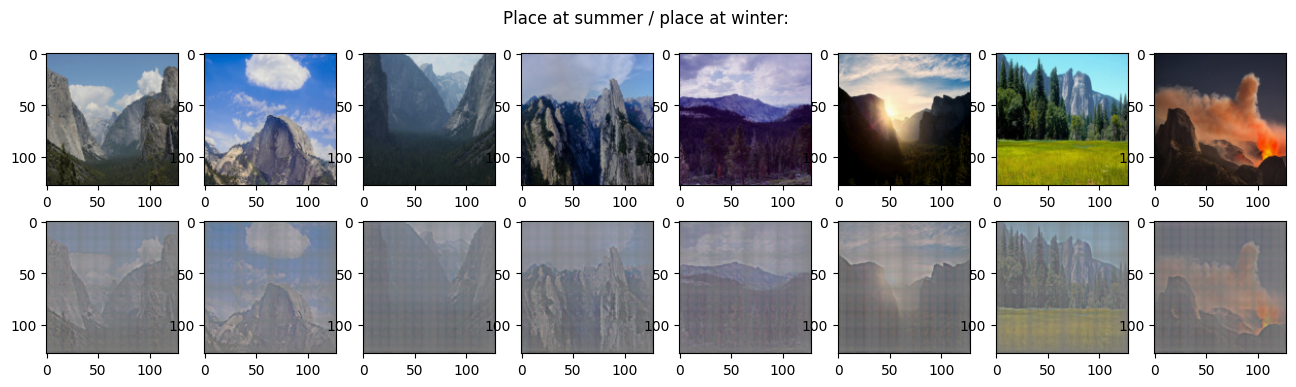

In [16]:
Val_iter = iter(dataVal)
X_test = dataVal.dataset.take(next(Val_iter)[0], A=True).to(trainer.loss_c.theta_device())
X_test.requires_grad_(True)
Y_generated = trainer.generate(X_test).detach().cpu()

cols = 8

# Visualize
fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16, 4))
fig.suptitle('Place at summer / place at winter:')

for i in range(cols):
    X_img = np.asarray(dataVal.dataset.to_image(X_test.detach().cpu())[i], dtype=np.uint8)
    _ = axes[0][i].imshow(X_img)

    Y_img = np.asarray(dataVal.dataset.to_image(Y_generated.cpu())[i], dtype=np.uint8)
    _ = axes[1][i].imshow(Y_img)

#plt.tight_layout()
fig.show()